# Simple Hierarchical Model with Numpyro: Cookie Chips Example

This notebook presents a simple example of a hierarchical model using [`NumPyro`](https://num.pyro.ai/en/latest/index.html#). The example is based on the cookie chips example in presented in the post [Introduction to Bayesian Modeling with PyMC3](https://juanitorduz.github.io/intro_pymc3/). There are many great resources regarding bayesian hierarchical model and probabilistic programming [`NumPyro`](https://num.pyro.ai/en/latest/index.html#). This notebook aims to provide a succinct simple example to get started. 

**Remark:** Well, the real reason is that I want to get acquainted other probabilistic programming libraries in order to abstract the core principles of probabilistic programming.

**References:**
- [`NumPyro` Getting Started](https://num.pyro.ai/en/latest/getting_started.html)
- [`NumPyro` Examples and Tutorials](https://num.pyro.ai/en/latest/index.html#introductory-tutorials)
- [An astronomer's introduction to NumPyro](https://dfm.io/posts/intro-to-numpyro/)
- [Finally! Bayesian Hierarchical Modelling at Scale](https://florianwilhelm.info/2020/10/bayesian_hierarchical_modelling_at_scale/)

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.preprocessing import LabelEncoder

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=0)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

The data set is described in the post [Introduction to Bayesian Modeling with PyMC3](https://juanitorduz.github.io/intro_pymc3/). It contains a sample  the number of chocolate `chips` cookies have when produced in different `locations`. There is a global recipe for the cookies, but each location might influence the number of chips in the cookies. Out objective is to understand the difference per location and, eventually, estimate the number of cookies for a new location not present in the dataset.

In [2]:
cookies = pd.read_csv("../data/cookies.dat", sep=" ")

cookies["location"] = pd.Categorical(values=cookies["location"])

n_locations = cookies["location"].nunique()

cookies.head()


,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


## EDA

We start by exploring the data. First, we plot the distribution of the number of chips per cookie on for all locations together.

[Text(0.5, 1.0, 'Cookie Chips'), Text(0.5, 0, 'chips'), Text(0, 0.5, 'count')]

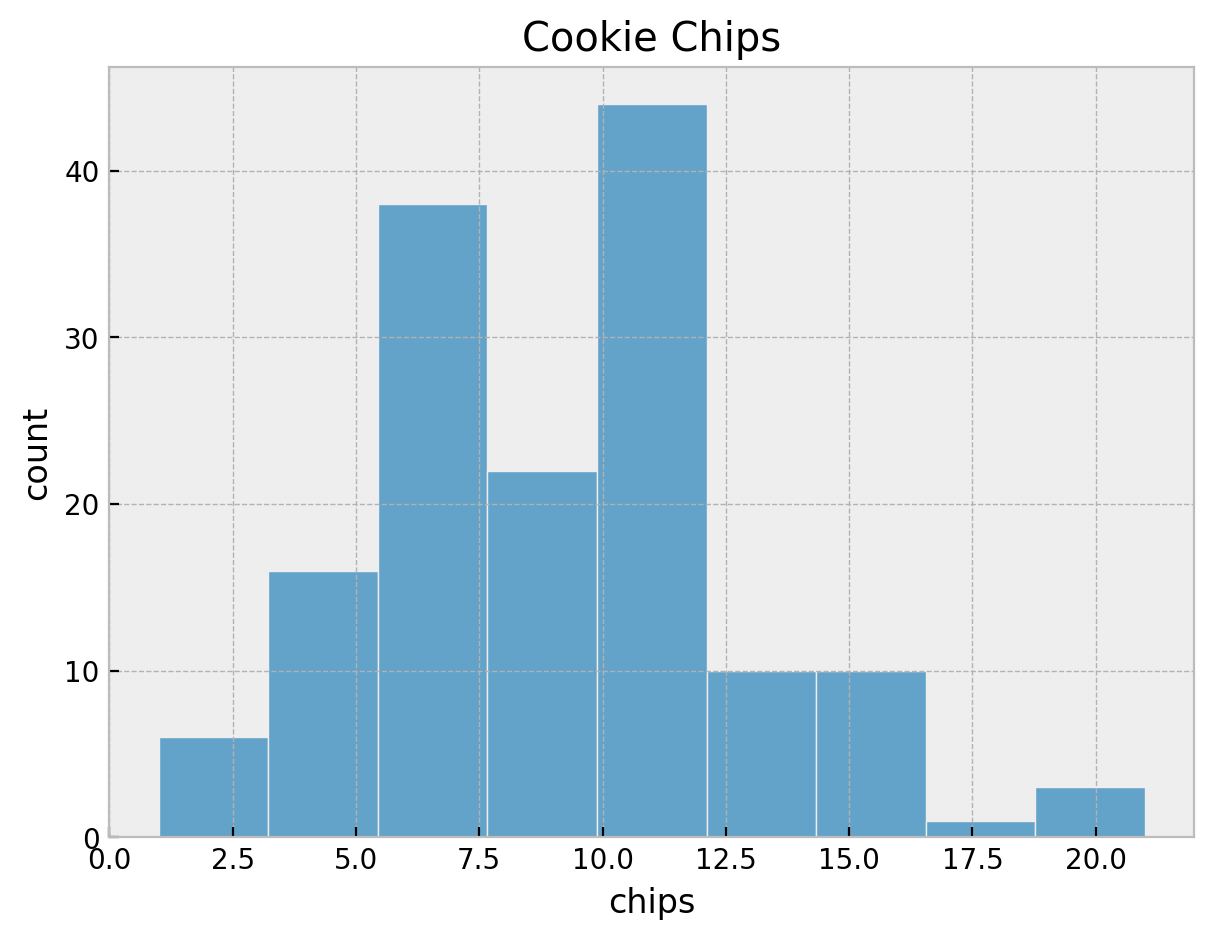

In [3]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(x=cookies["chips"], ax=ax)
ax.set(title="Cookie Chips", xlabel="chips", ylabel="count")


It seems we do not have an unimodal distribution. Let's look into some statistics.

In [4]:
cookies["chips"].describe()


count    150.000000
mean       9.153333
std        3.829831
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       21.000000
Name: chips, dtype: float64

The variance is different from the mean:

In [5]:
cookies["chips"].describe()["std"] ** 2


14.667606263982103

This hints that a Poisson distribution might not be the best choice because this over dispersion. An alternative is to use a Negative Binomial distribution. However, for the sake of simplicity, we will use a Poisson distribution (see below).

We can see that there are $5$ locations and $30$ samples per location.

Text(0.5, 1.03, 'Cookies Chips by Location')

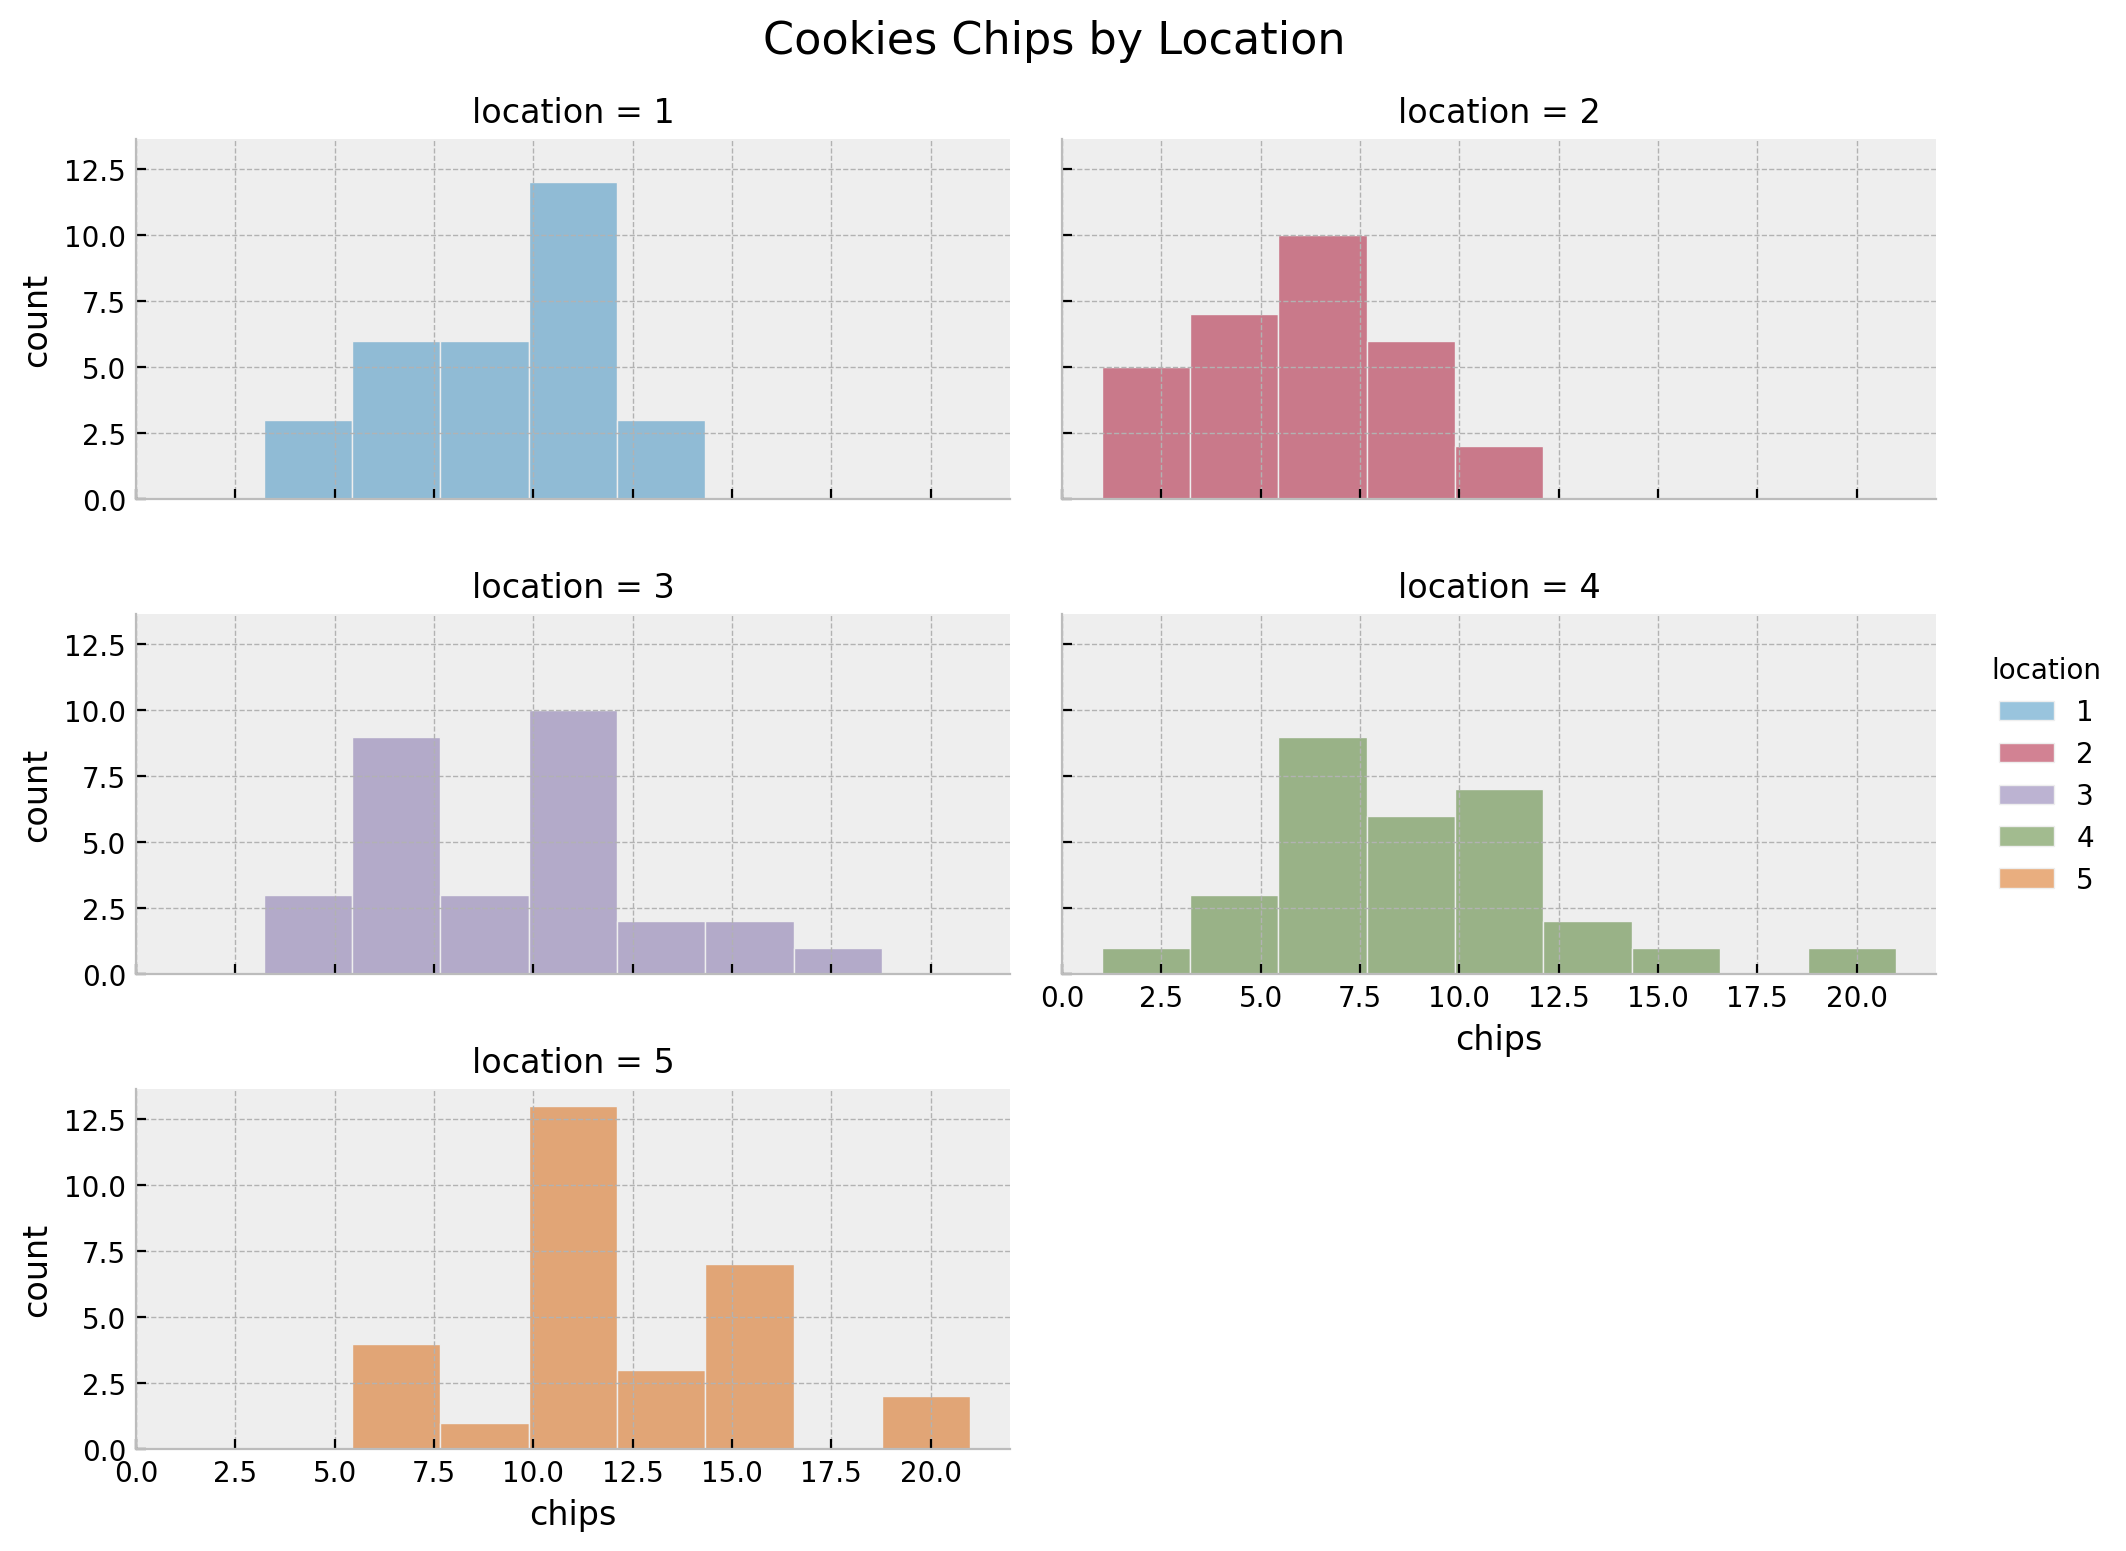

In [6]:
g = sns.displot(
    data=cookies,
    x="chips",
    kind="hist",
    hue="location",
    col="location",
    col_wrap=2,
    height=2.5,
    aspect=2,
)
g.set_xlabels("chips")
g.set_ylabels("count")
g.fig.suptitle("Cookies Chips by Location", y=1.03, fontsize=16)

[Text(0.5, 1.0, 'Cookies Chips by Location'),
 Text(0.5, 0, 'location'),
 Text(0, 0.5, 'chips')]

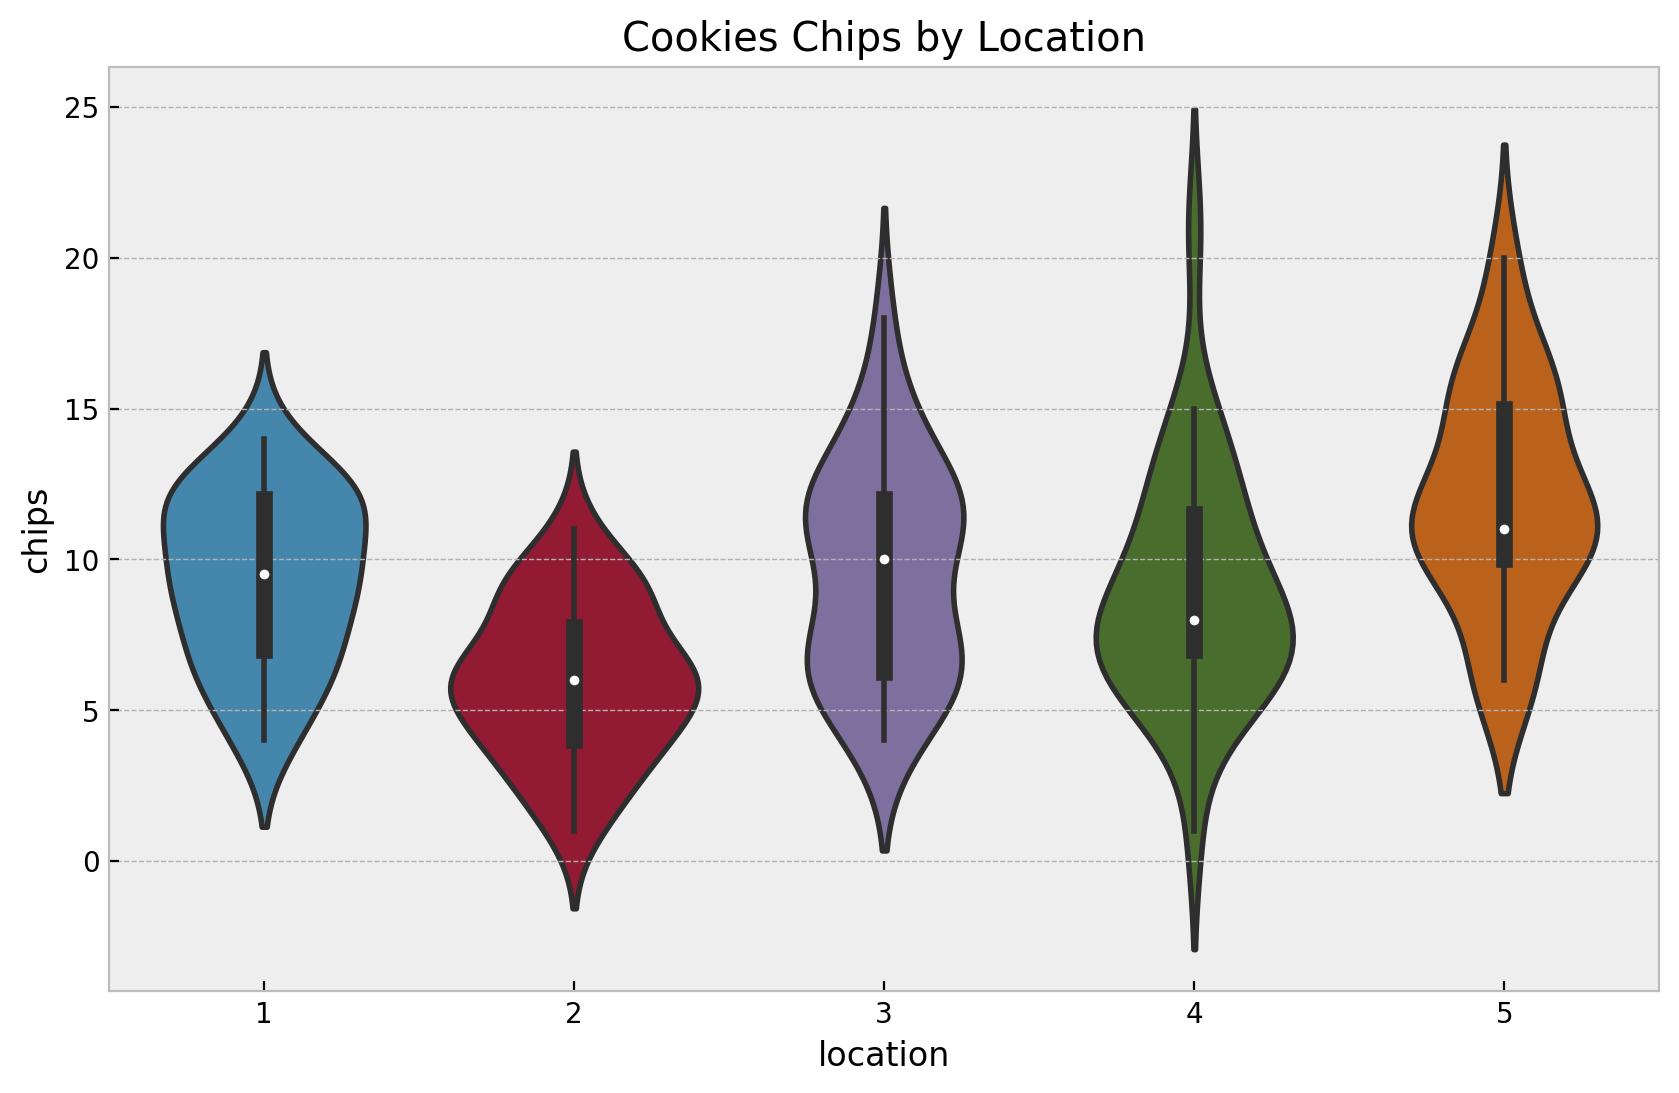

In [7]:
fig, ax = plt.subplots()
sns.violinplot(
    data=cookies,
    x="location",
    y="chips",
    ax=ax,
)
ax.set(title="Cookies Chips by Location", xlabel="location", ylabel="chips")


Again, let's look into some statistics.

In [8]:
cookies.groupby("location").agg(
    {"chips": ["count", "min", "max", "median", "mean", "var"]}
)

chips                                     
         count min max median       mean        var
location                                           
1           30   4  14    9.5   9.300000   8.010345
2           30   1  11    6.0   5.966667   6.447126
3           30   4  18   10.0   9.566667  13.012644
4           30   1  21    8.0   8.933333  15.029885
5           30   6  20   11.0  12.000000  13.724138

In this case we see that besides locations $3$ and $4$, the means and the variances are similar.

For  modeling purposes, we use a [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to encode the locations as integers.

In [9]:
location_encoder = LabelEncoder()

locations = location_encoder.fit_transform(cookies["location"])
locations = jnp.array(locations)

chips = cookies["chips"].to_numpy()
chips = jnp.array(chips)


## Pooled Model

We start with a simple baseline model where we assume that all locations have the same mean number of chips per cookie. We use a Poisson distribution to model the number of chips per cookie. To specify the model we need to wrap the model specification in a function, which takes as arguments the input data. We also choose a gamma prior for the rate parameter of the Poisson distribution.

\begin{align*}
\text{chips} & \sim \text{Poisson}(\text{rate}) \\
\text{rate}  & \sim \text{Gamma}(\alpha=2, \beta=1/5)
\end{align*}

In [10]:
def pooled_model(locations: ArrayImpl, chips: ArrayImpl | None = None) -> None:
    """Pooled model for cookie chips. We model the number of chips as a Poisson
    distribution and we assume that the rate is the same for all locations.
    """
    # priors
    lam = numpyro.sample(name="lam", fn=dist.Gamma(concentration=2, rate=1 / 5))

    n_obs = locations.size
    rate = numpyro.deterministic(name="rate", value=lam)
    # likelihood
    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(name="obs", fn=dist.Poisson(rate=rate), obs=chips)


We can visualize the model structure.

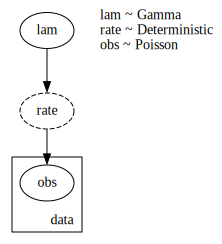

In [11]:
numpyro.render_model(
    model=pooled_model,
    model_args=(chips,),
    render_distributions=True,
    render_params=True,
)

Before inference, let's check the model specification by sampling from the prior.

Text(0.5, 1.05, 'Pooled Model Prior Predictive Samples')

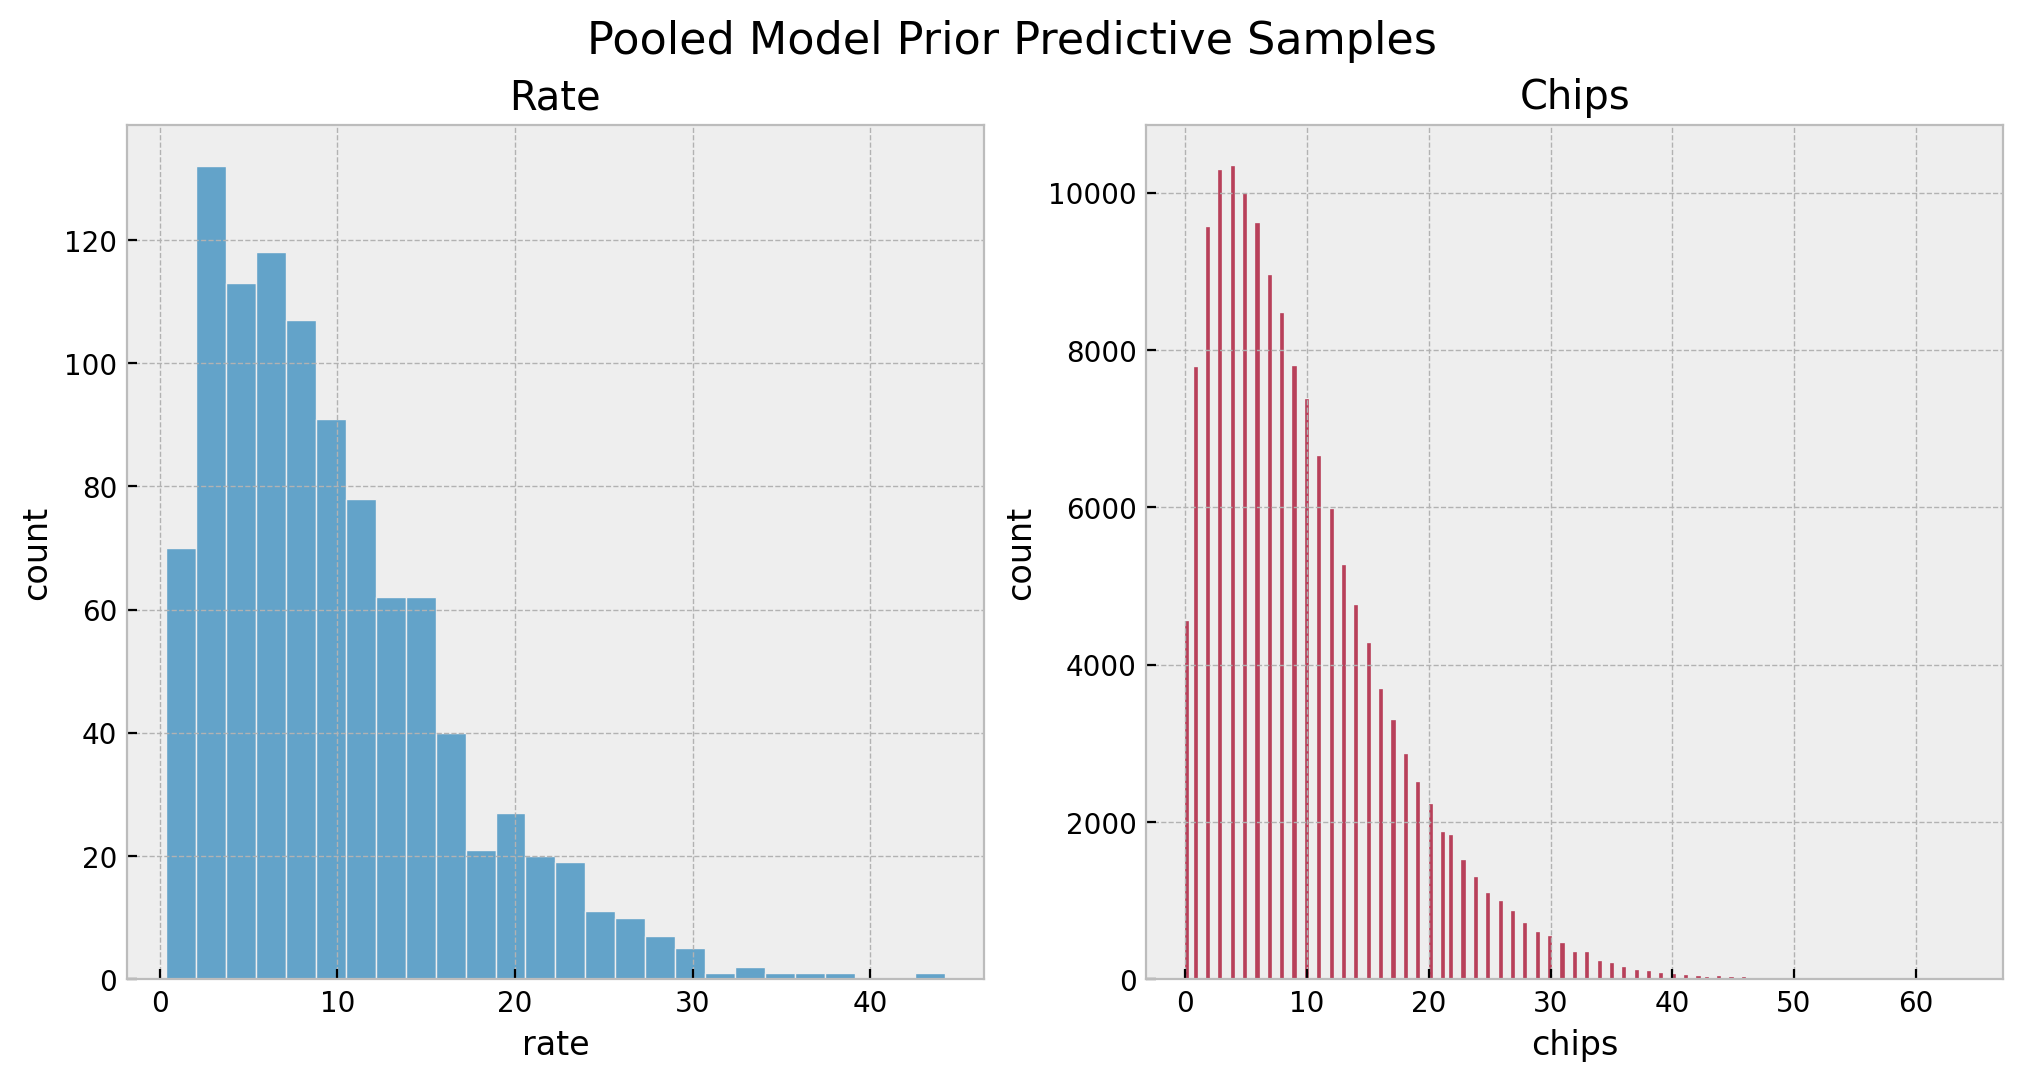

In [12]:
# prior predictive samples
pooled_prior_predictive = Predictive(model=pooled_model, num_samples=1_000)
rng_key, rng_subkey = random.split(rng_key)
pooled_prior_predictive_samples = pooled_prior_predictive(
    rng_key=rng_subkey, locations=locations
)
# plot
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 5), sharex=False, sharey=False, layout="constrained"
)
sns.histplot(x=pooled_prior_predictive_samples["rate"], color="C0", ax=ax[0])
ax[0].set(title="Rate", xlabel="rate", ylabel="count")
sns.histplot(x=pooled_prior_predictive_samples["obs"].flatten(), color="C1", ax=ax[1])
ax[1].set(title="Chips", xlabel="chips", ylabel="count")
fig.suptitle("Pooled Model Prior Predictive Samples", y=1.05, fontsize=16)

Overall, we see that the priors are reasonable as they bound the number of chips to a realistic domain without being too restrictive.

Now we are ready to perform inference using the [NUTS sampler](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo#No_U-Turn_Sampler).

In [13]:
# set sampler
pooled_nuts_kernel = NUTS(model=pooled_model, target_accept_prob=0.9)
pooled_mcmc = MCMC(
    sampler=pooled_nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4
)
# run sampler
rng_key, rng_subkey = random.split(key=rng_key)
pooled_mcmc.run(rng_subkey, locations, chips)
# get posterior samples
pooled_posterior_samples = pooled_mcmc.get_samples()
# get posterior predictive samples
pooled_posterior_predictive = Predictive(
    model=pooled_model, posterior_samples=pooled_posterior_samples
)
rng_key, rng_subkey = random.split(rng_key)
pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, locations)
# convert to arviz inference data object
pooled_idata = az.from_numpyro(
    posterior=pooled_mcmc, posterior_predictive=pooled_posterior_predictive_samples
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Let's check the estimated rate parameter.

In [14]:
az.summary(data=pooled_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,9.158,0.243,8.712,9.62,0.003,0.002,6014.0,6225.0,1.0
rate,9.158,0.243,8.712,9.62,0.003,0.002,6014.0,6225.0,1.0


We can also look into the trace:

Text(0.5, 0.98, 'Pooled Model Trace')

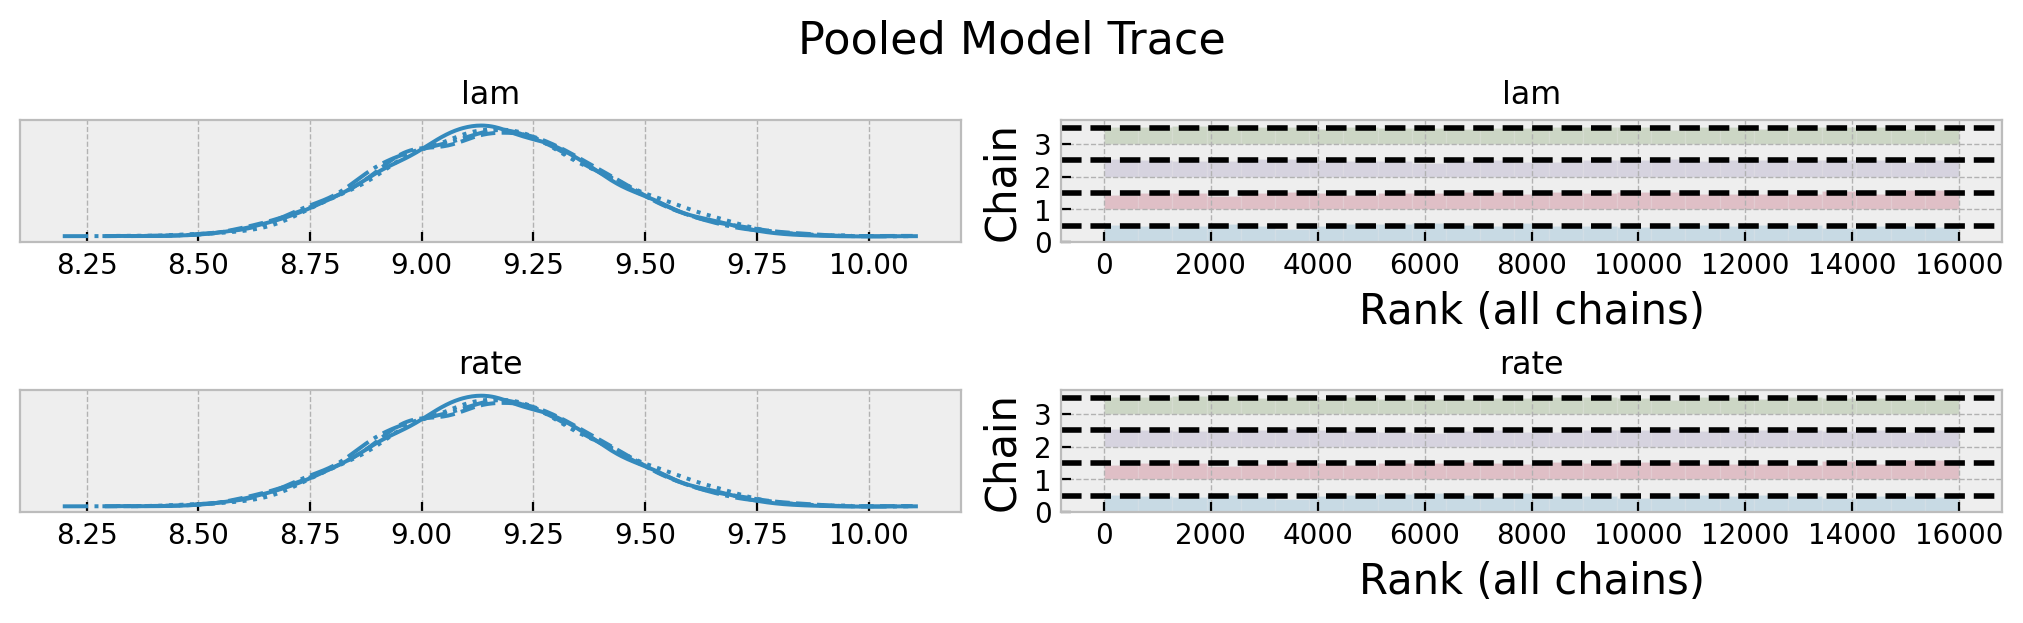

In [15]:
axes = az.plot_trace(
    data=pooled_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 3), "layout": "constrained"},
)
plt.gcf().suptitle("Pooled Model Trace", fontsize=16)

Overall, it looks good! Let's look into the posterior predictive distribution.

[Text(0.5, 1.0, 'Pooled Model Posterior Predictive Check'),
 Text(0.5, 0, 'chips'),
 Text(0, 0.5, 'count')]

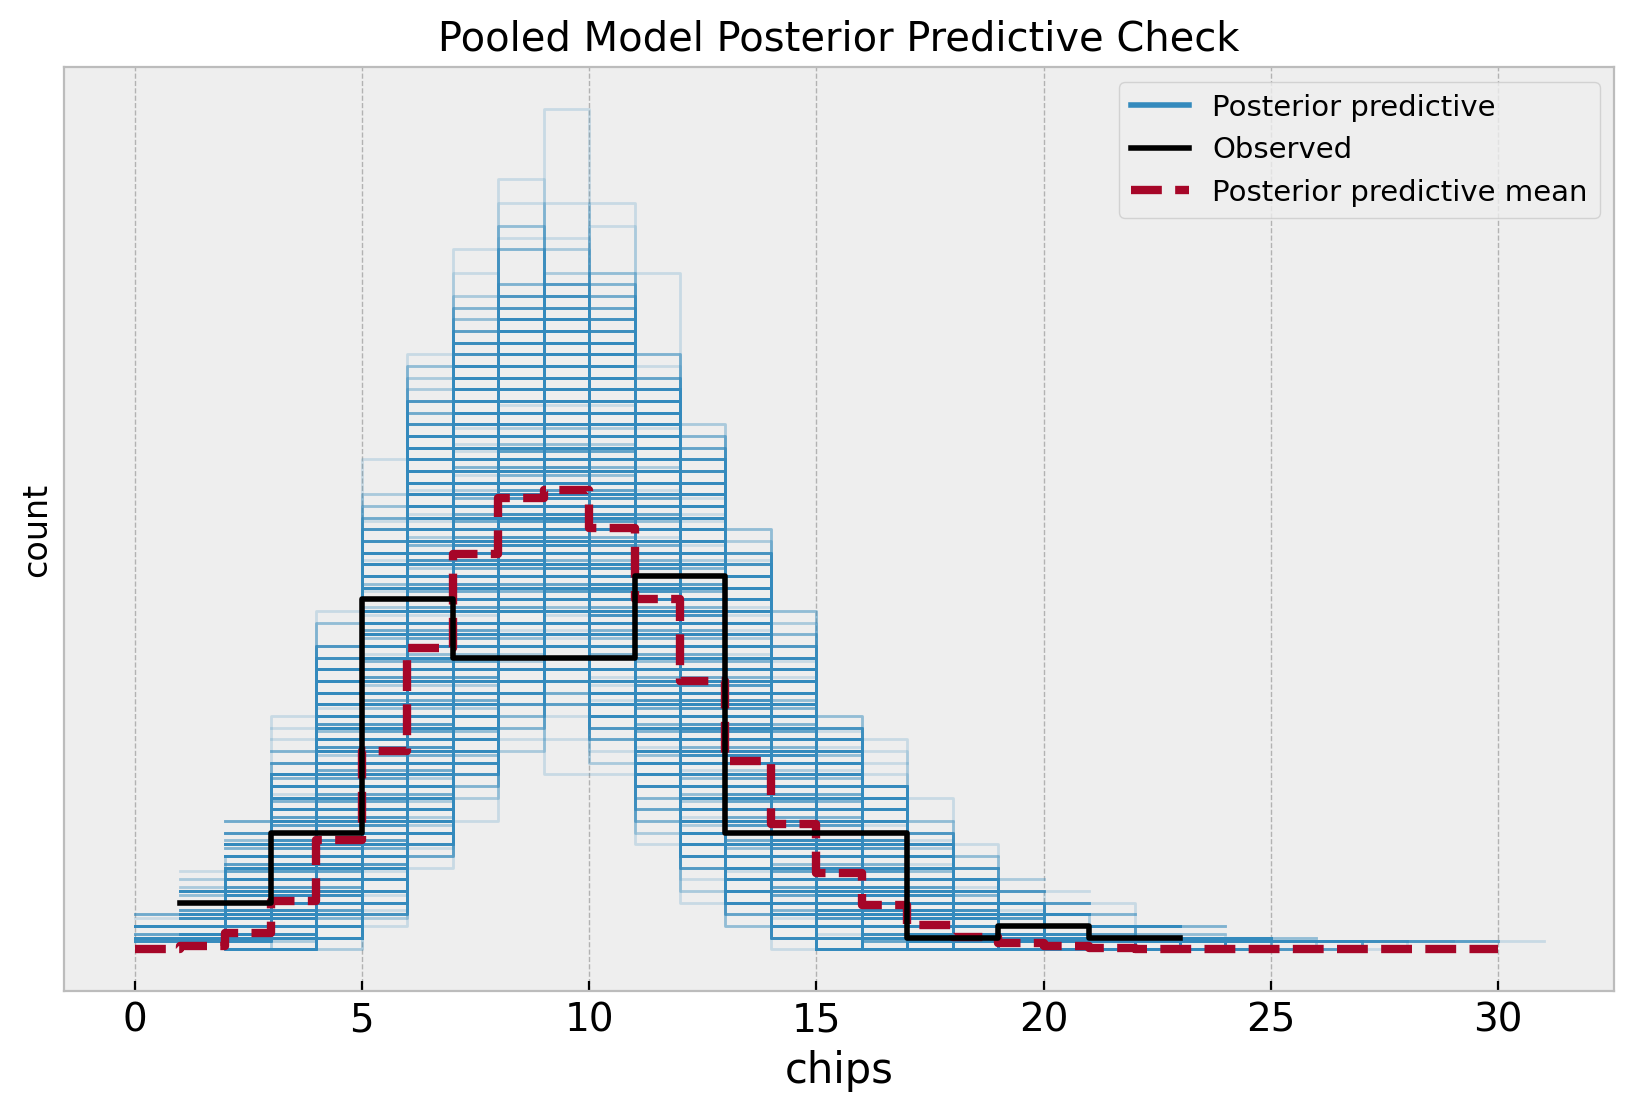

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_ppc(
    data=pooled_idata,
    observed_rug=True,
    ax=ax,
)
ax.set(
    title="Pooled Model Posterior Predictive Check",
    xlabel="chips",
    ylabel="count",
)

Note that the posterior distribution misses the two apparent modes in the sample distribution. This is no surprise as the model does not capture the difference between locations.

## Unpooled Model

Now we consider the opposite approach and fit independent rate parameters for each location. That is, we forget about the global recipe and assume that each location has its own recipe.

\begin{align*}
\text{chips}_{\ell} & \sim \text{Poisson}(\text{rate}_{[\ell]}) \\
\text{rate}_{[\ell]}  & \sim \text{Gamma}(\alpha=2, \beta=1/5), \quad \ell = 1, \ldots, 5
\end{align*}

In [17]:
def unpooled_model(locations: ArrayImpl, chips: ArrayImpl | None = None) -> None:
    """Unpooled model for cookie chips. We model the number of chips as a Poisson
    distribution and we assume that each location has its own independent rate.
    """
    n_locations = np.unique(locations).size

    with numpyro.plate(name="location", size=n_locations):
        lam = numpyro.sample(name="lam", fn=dist.Gamma(concentration=2, rate=1 / 5))

    n_obs = locations.size
    rate = numpyro.deterministic(name="rate", value=lam[locations])

    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(name="obs", fn=dist.Poisson(rate=rate), obs=chips)


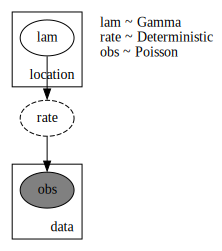

In [18]:
numpyro.render_model(
    model=unpooled_model,
    model_args=(locations, chips),
    render_distributions=True,
    render_params=True,
)

We start by looking into the prior predictive distributions per location.

Text(0.5, 1.05, 'Unpooled Model Prior Predictive Samples')

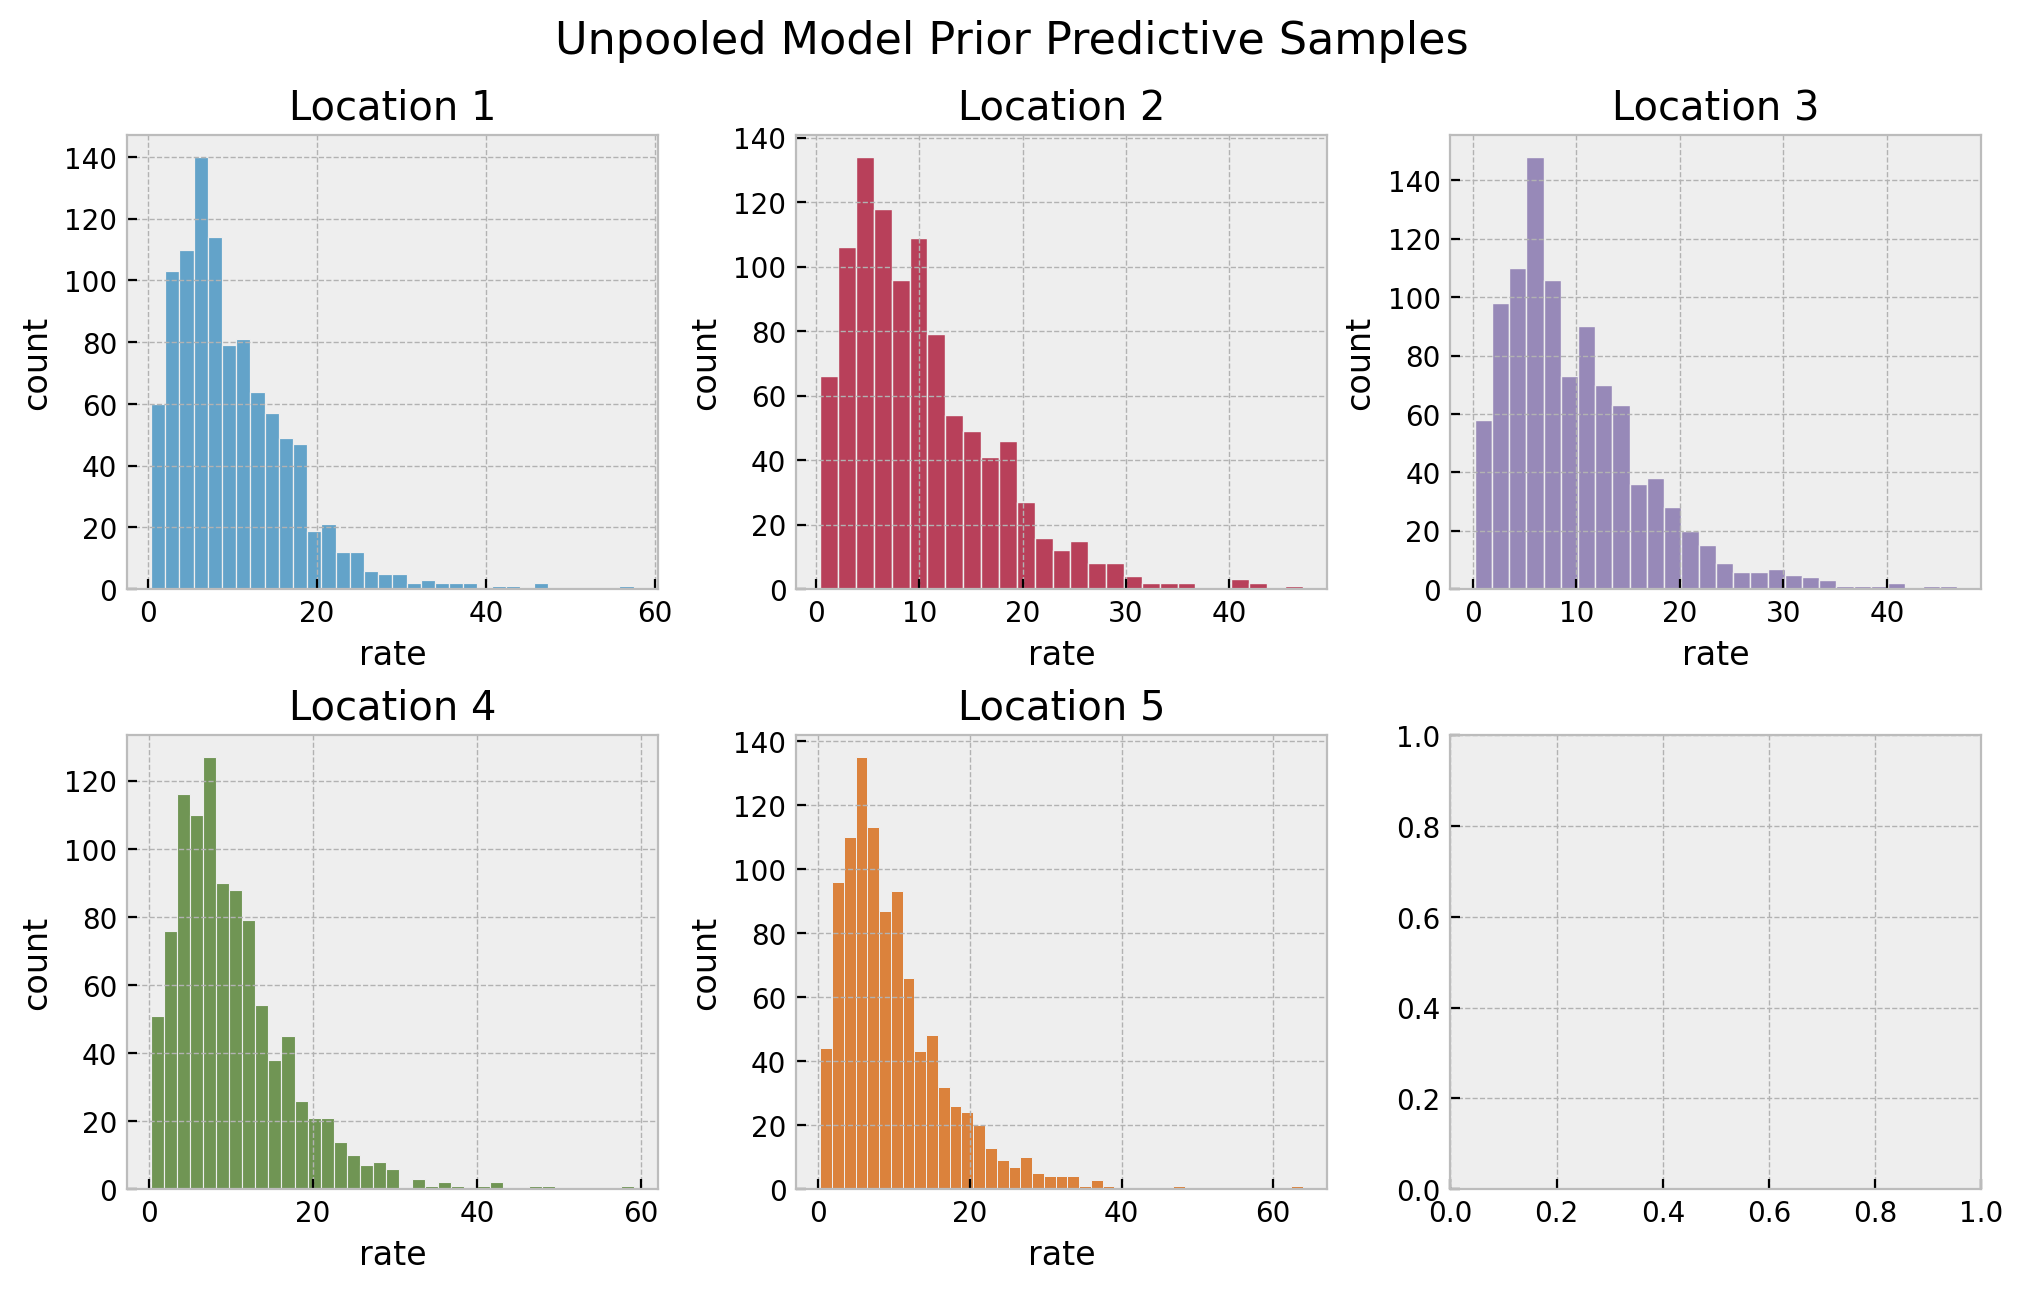

In [19]:
# prior predictive samples
unpooled_prior_predictive = Predictive(model=unpooled_model, num_samples=1_000)
rng_key, rng_subkey = random.split(rng_key)
unpooled_prior_predictive_samples = unpooled_prior_predictive(
    rng_key=rng_subkey, locations=locations
)

# plot
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(10, 6), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for location in range(1, n_locations + 1):
    ax = axes[location - 1]
    sns.histplot(
        x=unpooled_prior_predictive_samples["lam"][:, location - 1],
        color=f"C{location - 1}",
        ax=ax,
    )
    ax.set(title=f"Location {location}", xlabel="rate", ylabel="count")

fig.suptitle("Unpooled Model Prior Predictive Samples", y=1.05, fontsize=16)


They also look very reasonable. Let's now perform inference on the parameters.

In [20]:
# set sampler
unpooled_nuts_kernel = NUTS(model=unpooled_model, target_accept_prob=0.9)
unpooled_mcmc = MCMC(
    sampler=unpooled_nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4
)
# run sampler
rng_key, rng_subkey = random.split(key=rng_key)
unpooled_mcmc.run(rng_subkey, locations, chips)
# get posterior samples
unpooled_posterior_samples = unpooled_mcmc.get_samples()
# get posterior predictive samples
unpooled_posterior_predictive = Predictive(
    model=unpooled_model, posterior_samples=unpooled_posterior_samples
)
rng_key, rng_subkey = random.split(rng_key)
unpooled_posterior_predictive_samples = unpooled_posterior_predictive(
    rng_subkey, locations
)
# convert to arviz inference data object
unpooled_idata = az.from_numpyro(
    posterior=unpooled_mcmc,
    posterior_predictive=unpooled_posterior_predictive_samples,
    coords={"location": location_encoder.classes_},
    dims={"lam": ["location"]},
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [21]:
az.summary(data=unpooled_idata, var_names=["lam"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam[1],9.304,0.557,8.310,10.389,0.004,0.003,21462.0,11876.0,1.0
lam[2],5.992,0.449,5.121,6.817,0.003,0.002,20704.0,11988.0,1.0
lam[3],9.570,0.559,8.520,10.624,0.004,0.003,22239.0,11470.0,1.0
lam[4],8.944,0.544,7.919,9.971,0.004,0.003,21051.0,12612.0,1.0
lam[5],11.992,0.630,10.844,13.203,0.004,0.003,22277.0,11997.0,1.0


Text(0.5, 0.98, 'Unpooled Model Trace')

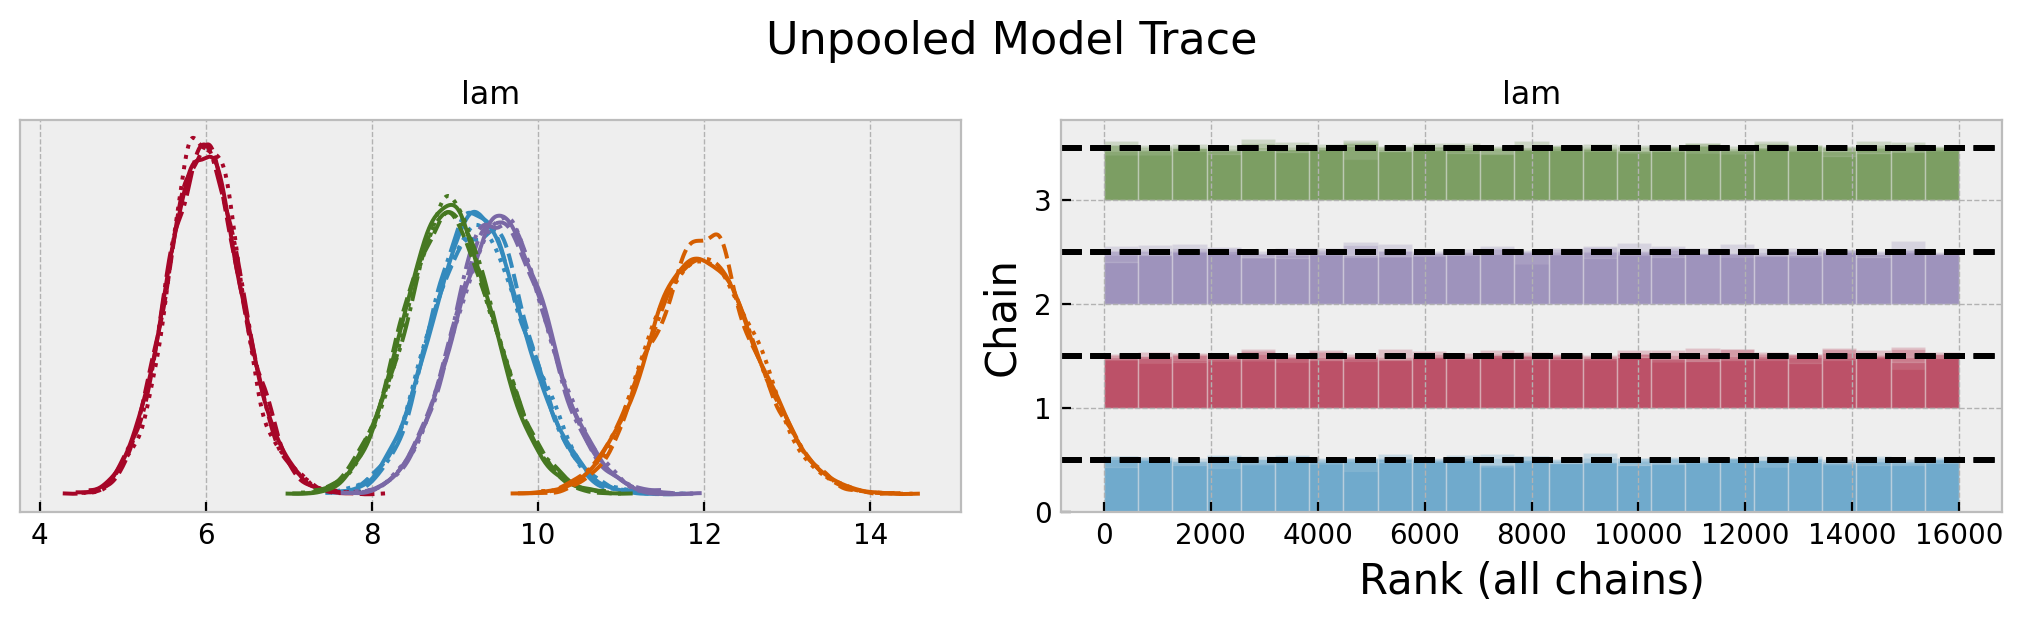

In [22]:
axes = az.plot_trace(
    data=unpooled_idata,
    var_names=["lam"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 3), "layout": "constrained"},
)
plt.gcf().suptitle("Unpooled Model Trace", fontsize=16)

We do se some differences in the rate parameters across locations. Let's look into the posterior predictive distributions.

[Text(0.5, 1.0, 'Unpooled Model Posterior Predictive Check'),
 Text(0.5, 0, 'chips'),
 Text(0, 0.5, 'count')]

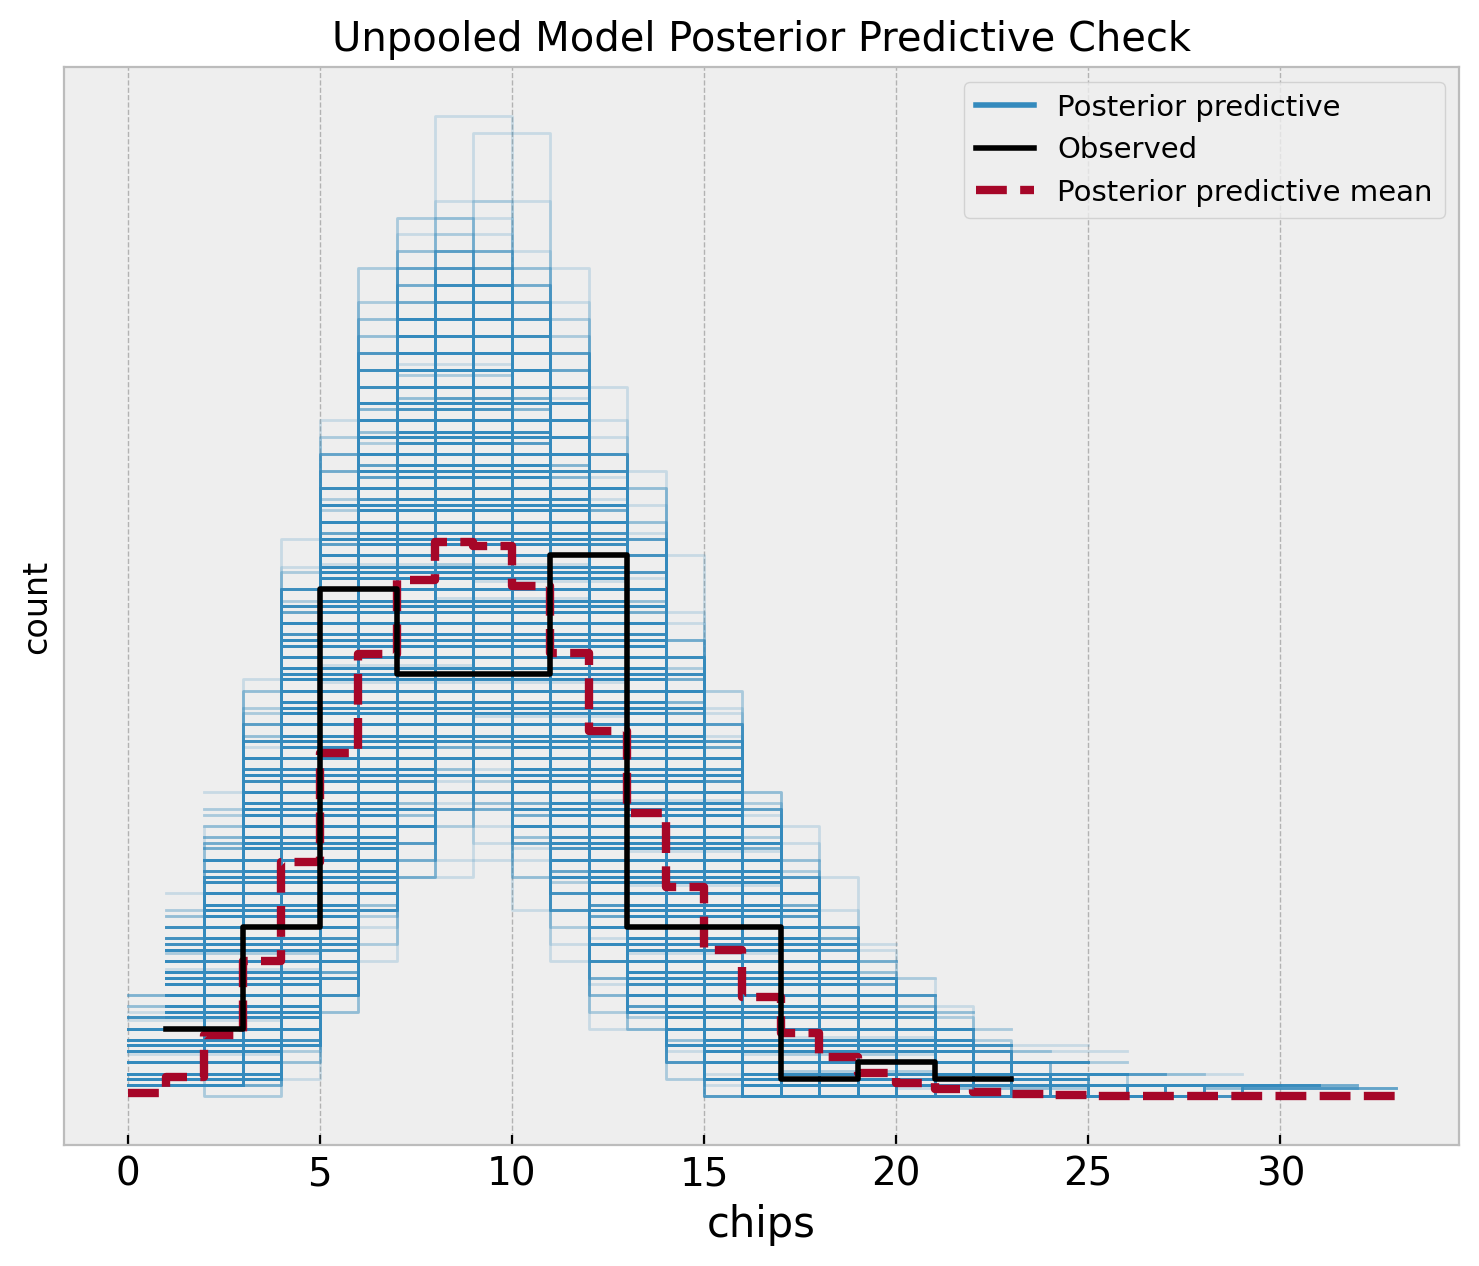

In [23]:
fig, ax = plt.subplots(figsize=(9, 7))
az.plot_ppc(
    data=unpooled_idata,
    observed_rug=True,
    ax=ax,
)
ax.set(
    title="Unpooled Model Posterior Predictive Check",
    xlabel="chips",
    ylabel="count",
)

## Hierarchical Model

In the hierarchical approach we do assume each location has its own rate, but we also assume that the rate parameters are drawn from a common distribution. This is a way to share information across locations. The model is specified as follows:

\begin{align*}
\text{chips}_{[\ell]} & \sim \text{Poisson}(\text{rate}_{[\ell]}) \\
\text{rate}_{[\ell]}  & \sim \text{Gamma}(\alpha=, \beta), \quad \ell = 1, \ldots, 5 \\
\alpha & = \frac{\mu^2}{\sigma^2} \\
\beta & = \frac{\mu}{\sigma^2} \\
\mu & \sim \text{Gamma}(2, 1/5) \\
\sigma & \sim \text{Exponential}(1)
\end{align*}

In [24]:
def hierarchical_model(locations: ArrayImpl, chips: ArrayImpl | None = None) -> None:
    mu = numpyro.sample(name="mu", fn=dist.Gamma(concentration=2, rate=1 / 5))
    sigma = numpyro.sample(name="sigma", fn=dist.Exponential(rate=1))
    alpha = numpyro.deterministic(name="alpha", value=mu**2 / sigma**2)
    beta = numpyro.deterministic(name="beta", value=mu / sigma**2)

    n_locations = np.unique(locations).size

    with numpyro.plate(name="location", size=n_locations):
        lam = numpyro.sample(
            name="lam",
            fn=dist.Gamma(concentration=alpha, rate=beta),
        )

    n_obs = locations.size
    rate = numpyro.deterministic(name="rate", value=lam[locations])

    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(name="obs", fn=dist.Poisson(rate=rate), obs=chips)


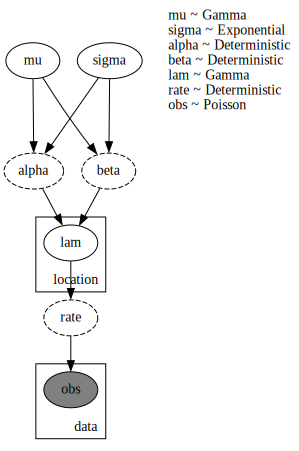

In [25]:
numpyro.render_model(
    hierarchical_model,
    model_args=(locations, chips),
    render_distributions=True,
    render_params=True,
)

We start by looking into the prior predictive distributions per location as we did before.

Text(0.5, 1.05, 'Hierarchical Model Prior Predictive Samples')

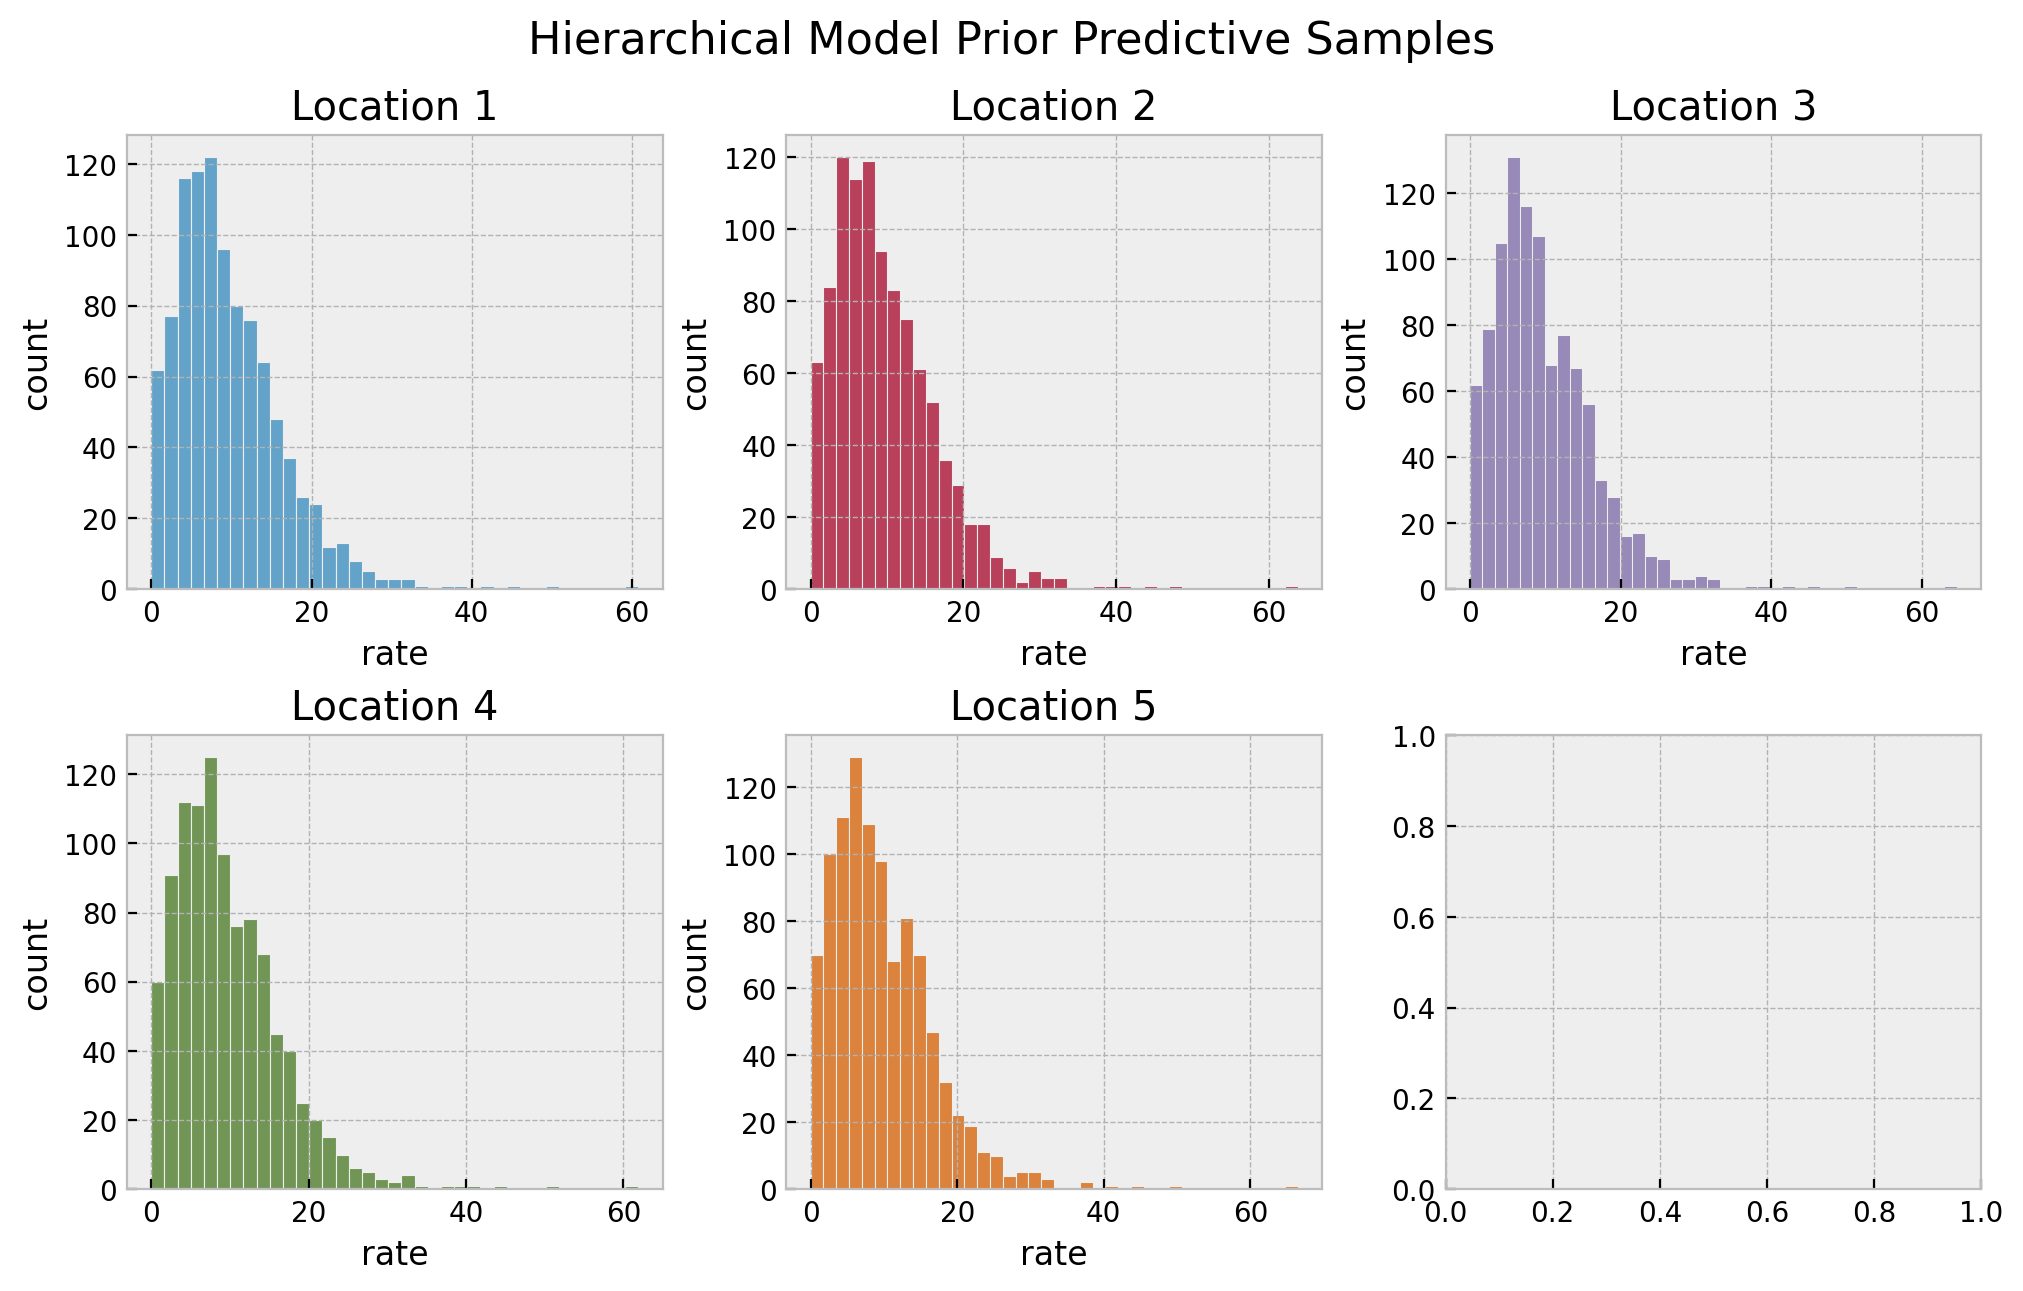

In [26]:
# prior predictive samples
hierarchical_prior_predictive = Predictive(model=hierarchical_model, num_samples=1_000)
rng_key, rng_subkey = random.split(rng_key)
hierarchical_prior_predictive_samples = hierarchical_prior_predictive(
    rng_key=rng_subkey, locations=locations
)

# plot
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(10, 6), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for location in range(1, n_locations + 1):
    ax = axes[location - 1]
    sns.histplot(
        x=hierarchical_prior_predictive_samples["lam"][:, location - 1],
        color=f"C{location - 1}",
        ax=ax,
    )
    ax.set(title=f"Location {location}", xlabel="rate", ylabel="count")

fig.suptitle("Hierarchical Model Prior Predictive Samples", y=1.05, fontsize=16)


The resulting distributions look plausible. We continue running the sampler to estimate the parameters.

In [27]:
# set sampler
hierarchical_nuts_kernel = NUTS(model=hierarchical_model, target_accept_prob=0.9)
hierarchical_mcmc = MCMC(
    sampler=hierarchical_nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4
)
# run sampler
rng_key, rng_subkey = random.split(key=rng_key)
hierarchical_mcmc.run(rng_subkey, locations, chips)
# get posterior samples
hierarchical_posterior_samples = hierarchical_mcmc.get_samples()
# get posterior predictive samples
hierarchical_posterior_predictive = Predictive(
    model=hierarchical_model, posterior_samples=hierarchical_posterior_samples
)
rng_key, rng_subkey = random.split(rng_key)
hierarchical_posterior_predictive_samples = hierarchical_posterior_predictive(
    rng_subkey, locations
)
# convert to arviz inference data object
hierarchical_idata = az.from_numpyro(
    posterior=hierarchical_mcmc,
    posterior_predictive=hierarchical_posterior_predictive_samples,
    coords={"location": location_encoder.classes_},
    dims={"lam": ["location"]},
)


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [28]:
az.summary(data=hierarchical_idata, var_names=["lam"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam[1],9.283,0.540,8.286,10.320,0.004,0.003,20168.0,10898.0,1.0
lam[2],6.224,0.467,5.355,7.105,0.003,0.002,18481.0,11851.0,1.0
lam[3],9.527,0.553,8.497,10.568,0.004,0.003,21564.0,11655.0,1.0
lam[4],8.947,0.526,8.031,9.998,0.004,0.003,20912.0,12649.0,1.0
lam[5],11.759,0.617,10.611,12.911,0.004,0.003,19434.0,12391.0,1.0


Text(0.5, 0.98, 'Hierarchical Model Trace')

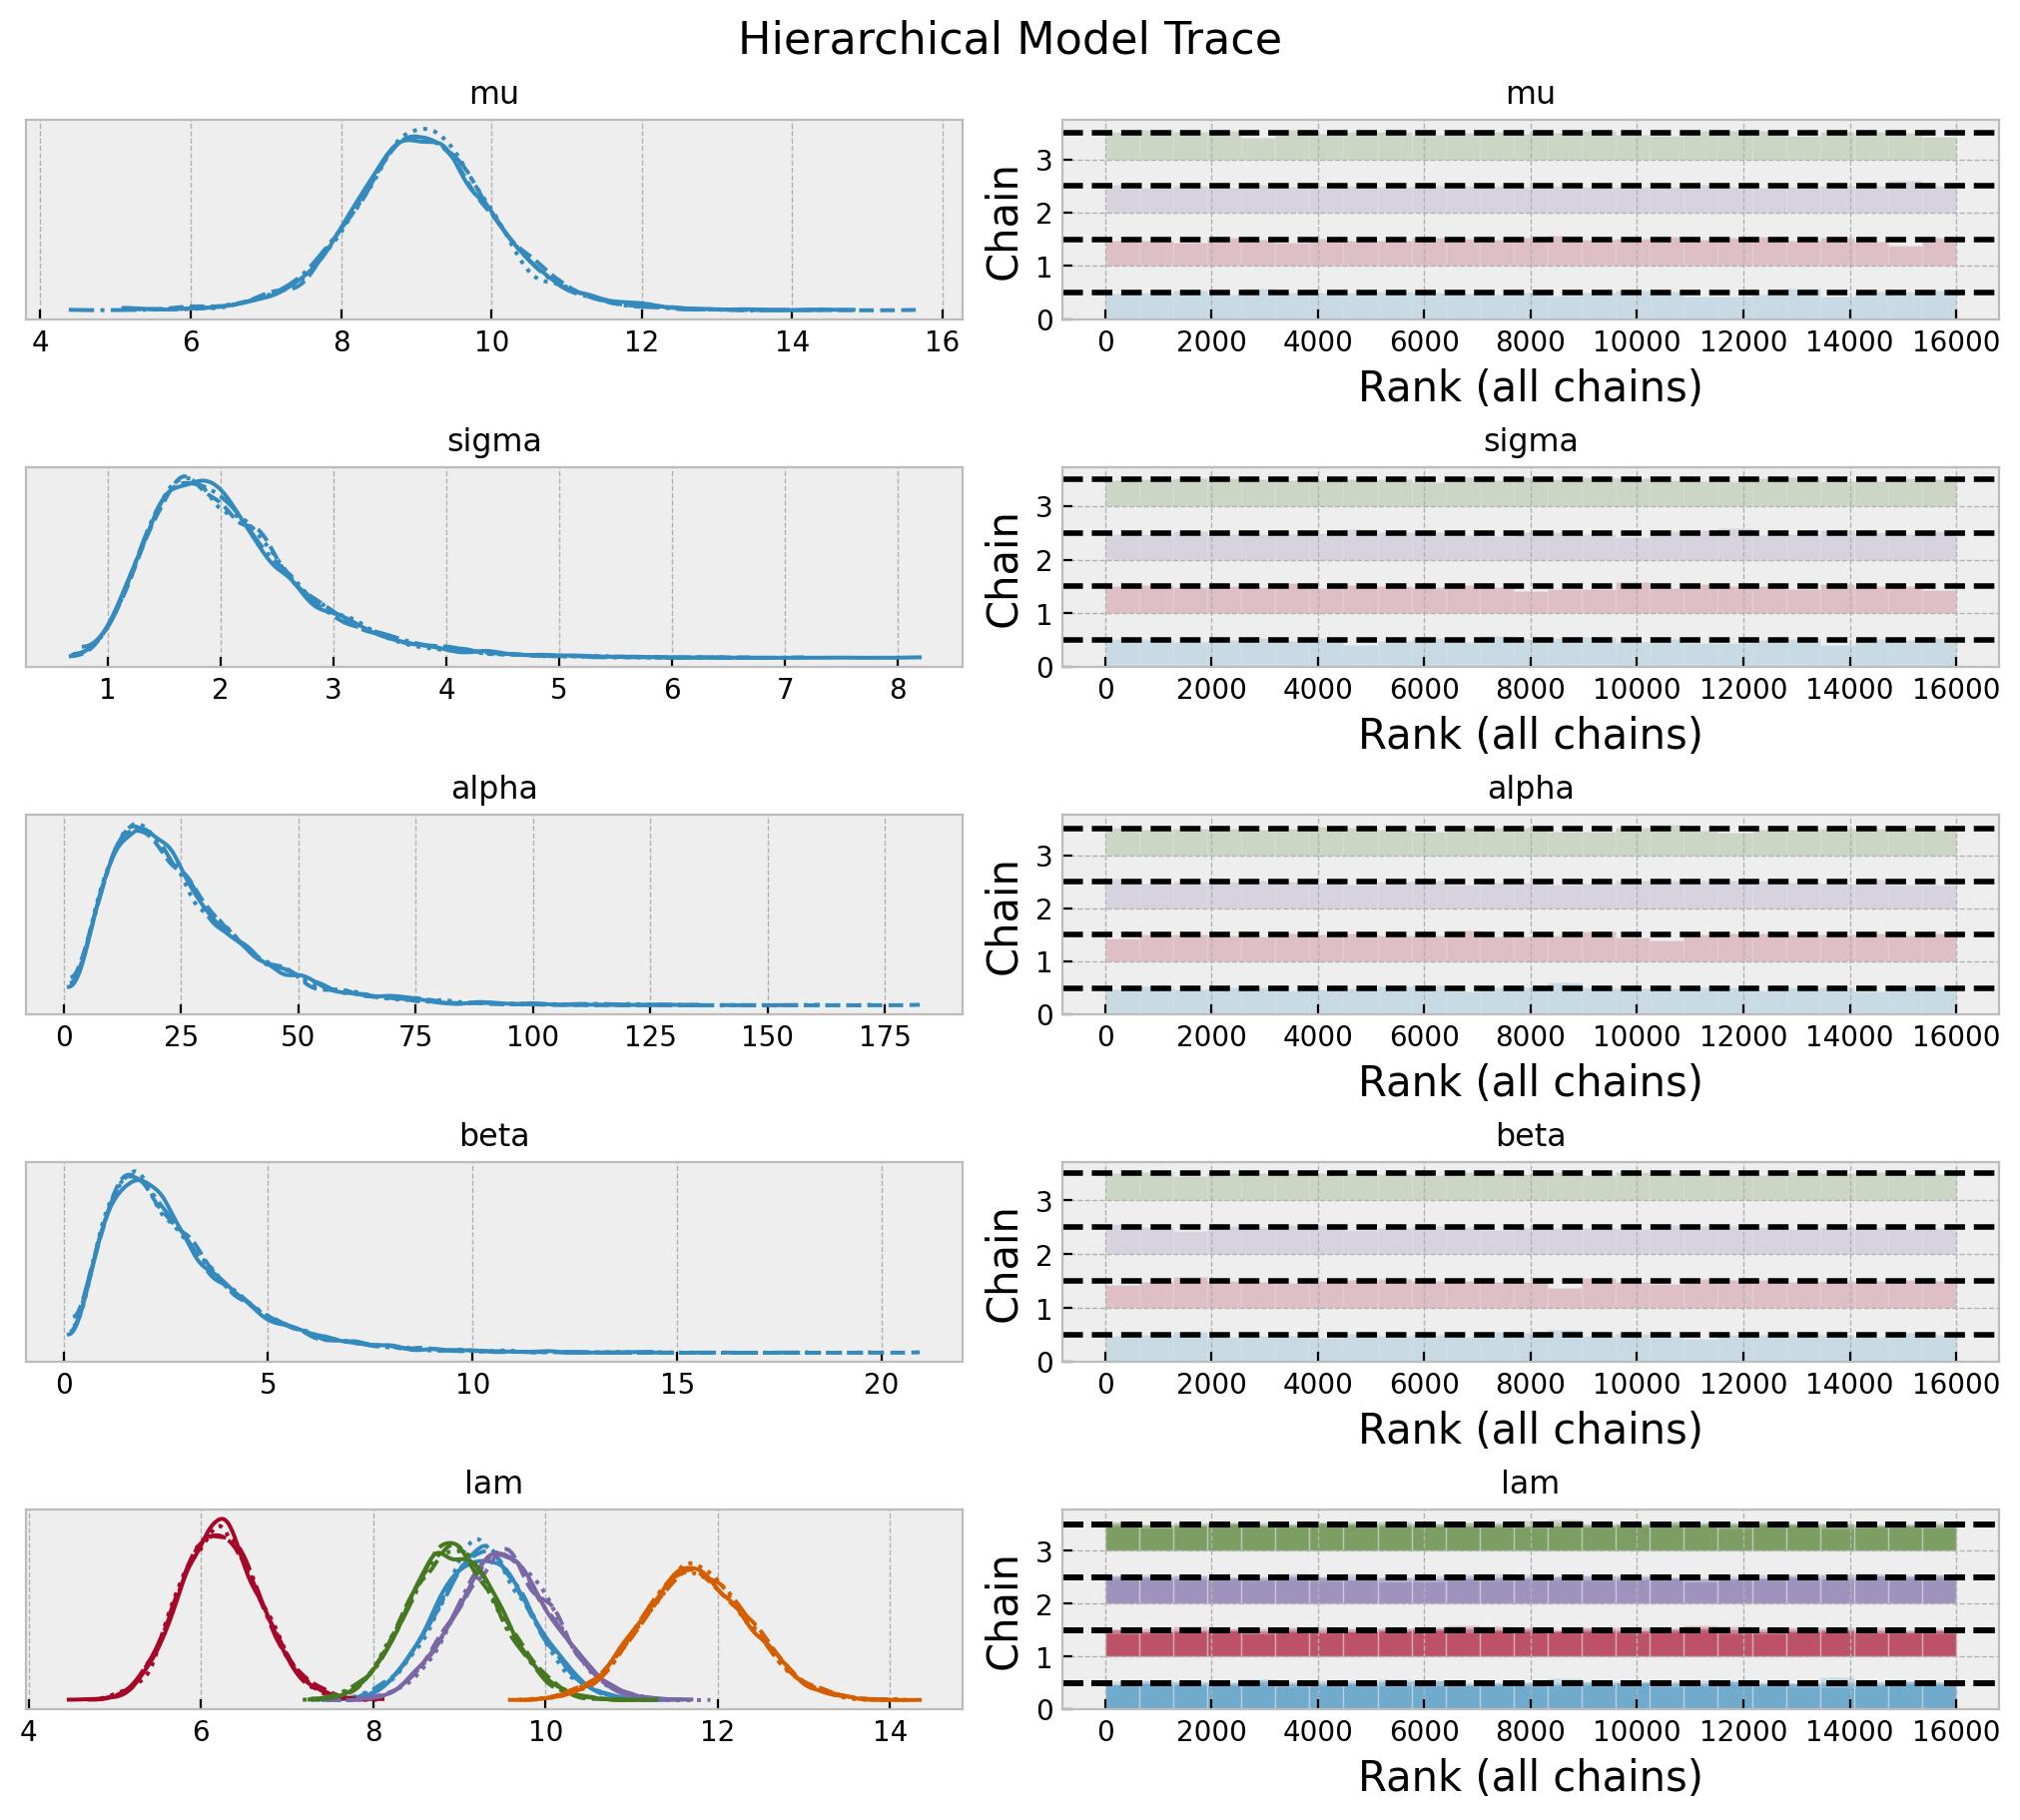

In [29]:
axes = az.plot_trace(
    data=hierarchical_idata,
    var_names=["mu", "sigma", "alpha", "beta", "lam"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Hierarchical Model Trace", fontsize=16)


[Text(0.5, 1.0, 'Hierarchical Model Posterior Predictive Check'),
 Text(0.5, 0, 'chips'),
 Text(0, 0.5, 'count')]

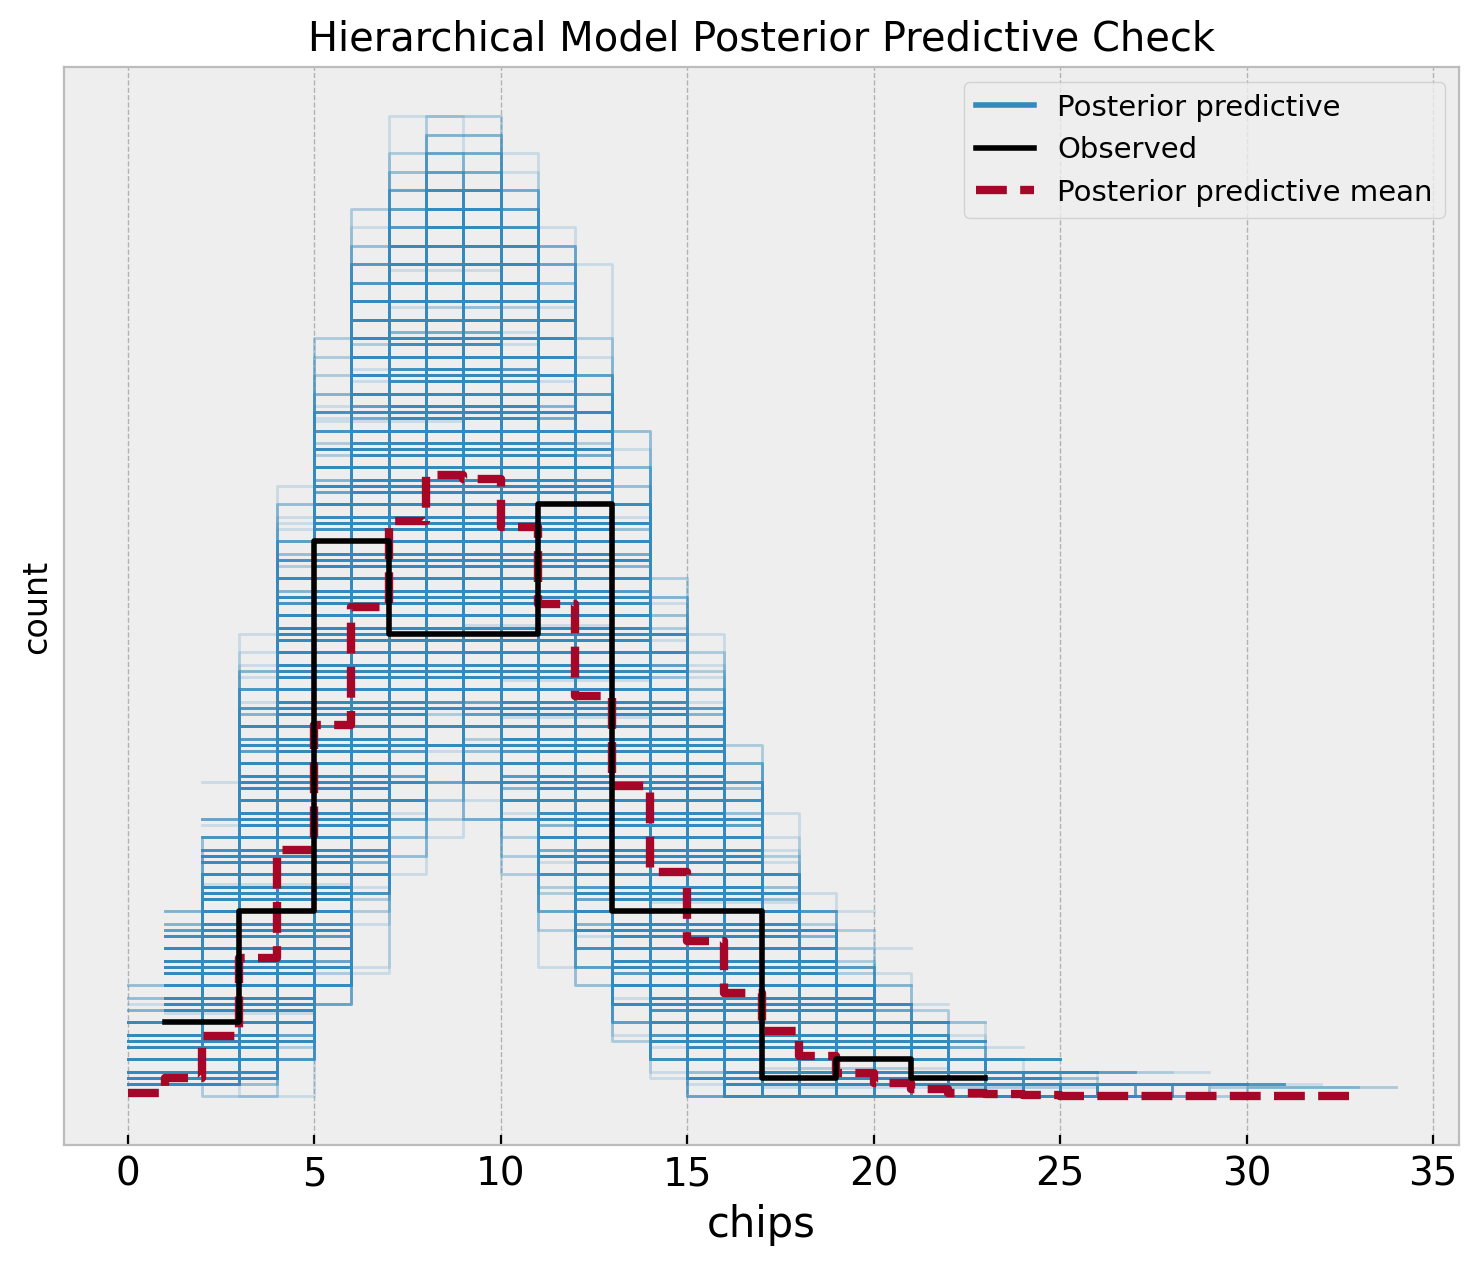

In [30]:
fig, ax = plt.subplots(figsize=(9, 7))
az.plot_ppc(
    data=hierarchical_idata,
    observed_rug=True,
    ax=ax,
)
ax.set(
    title="Hierarchical Model Posterior Predictive Check",
    xlabel="chips",
    ylabel="count",
)

## Model Comparison

Let's start by comparing the posterior predictive distributions for the three models.

Text(0.5, 1.06, 'Posterior Predictive Checks')

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


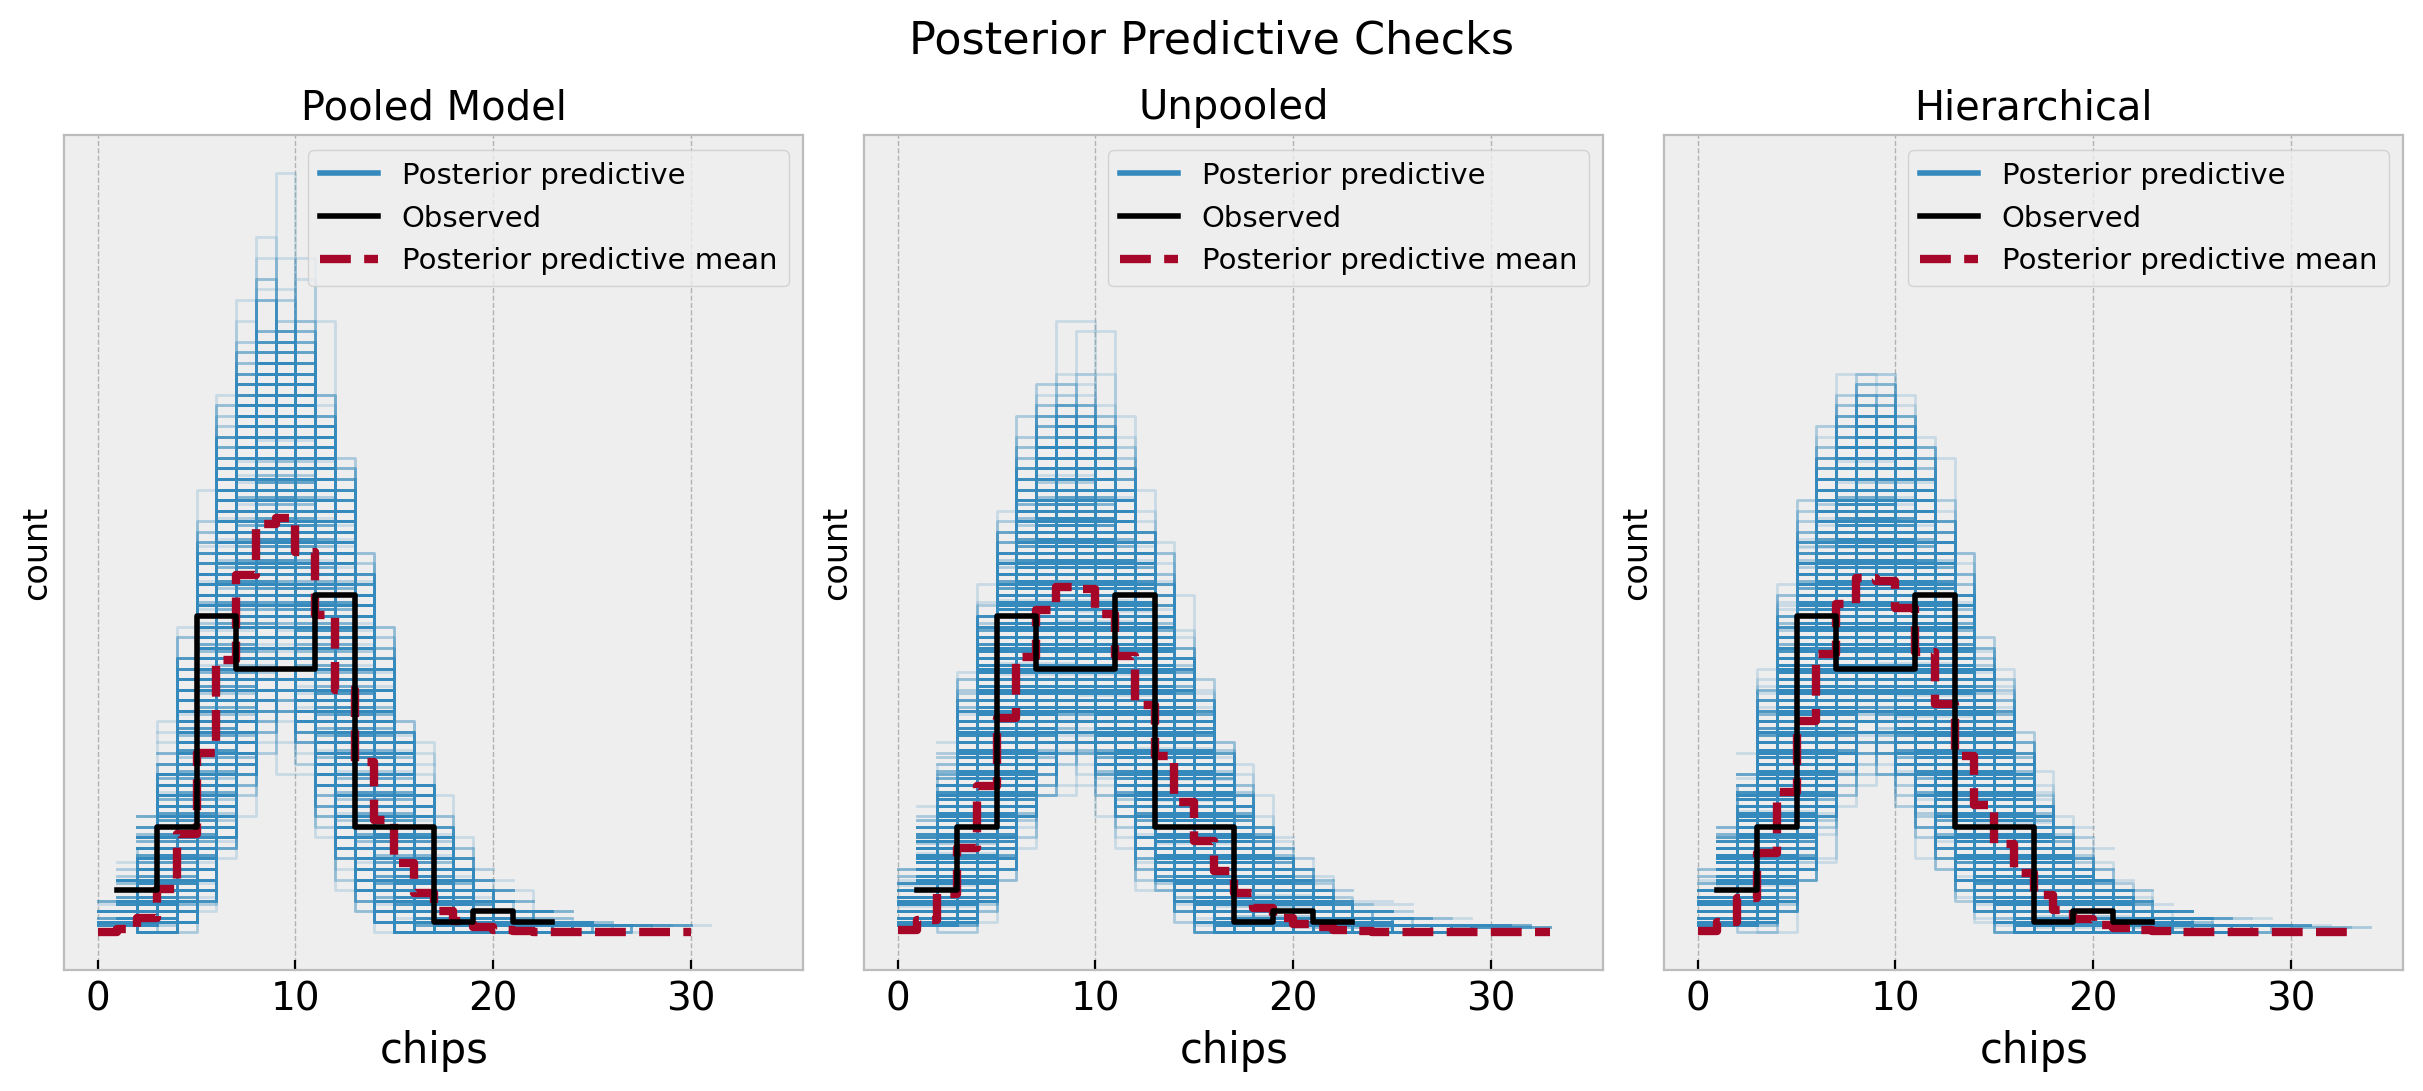

In [31]:
fig, ax = plt.subplots(
    nrows=1, ncols=3, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)

az.plot_ppc(
    data=pooled_idata,
    observed_rug=True,
    ax=ax[0],
)
ax[0].set(
    title="Pooled Model",
    xlabel="chips",
    ylabel="count",
)
az.plot_ppc(
    data=unpooled_idata,
    observed_rug=True,
    ax=ax[1],
)
ax[1].set(
    title="Unpooled",
    xlabel="chips",
    ylabel="count",
)
az.plot_ppc(
    data=hierarchical_idata,
    observed_rug=True,
    ax=ax[2],
)
ax[2].set(
    title="Hierarchical",
    xlabel="chips",
    ylabel="count",
)

fig.suptitle("Posterior Predictive Checks", y=1.06, fontsize=16)

The unpooled and hierarchical models are quite similar and overall better that the pooled model. Next, we can compare them through some statistics.

In [32]:
rng_key, rng_subkey = random.split(rng_key)
az.compare(
    compare_dict={
        "pooled": pooled_idata,
        "unpooled": unpooled_idata,
        "hierarchical": hierarchical_idata,
    },
    seed=rng_subkey,
)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
unpooled,0,-394.783500,5.981711,0.000000,0.942403,10.655966,0.000000,False,log
hierarchical,1,-394.870999,5.827696,0.087500,0.000000,10.676146,0.680974,False,log
pooled,2,-421.937956,1.544491,27.154456,0.057597,13.355439,8.665326,False,log


The results indeed show that the unpooled and hierarchical models are better than the pooled model. However, the difference between the unpooled and hierarchical models is not that big.

We can compare the estimated means of the rate parameters for each location across the three models.

[Text(0.5, 1.0, 'Rates Comparison'),
 Text(0.5, 0, 'unpooled model rate mean'),
 Text(0, 0.5, 'hierarchical model rate mean')]

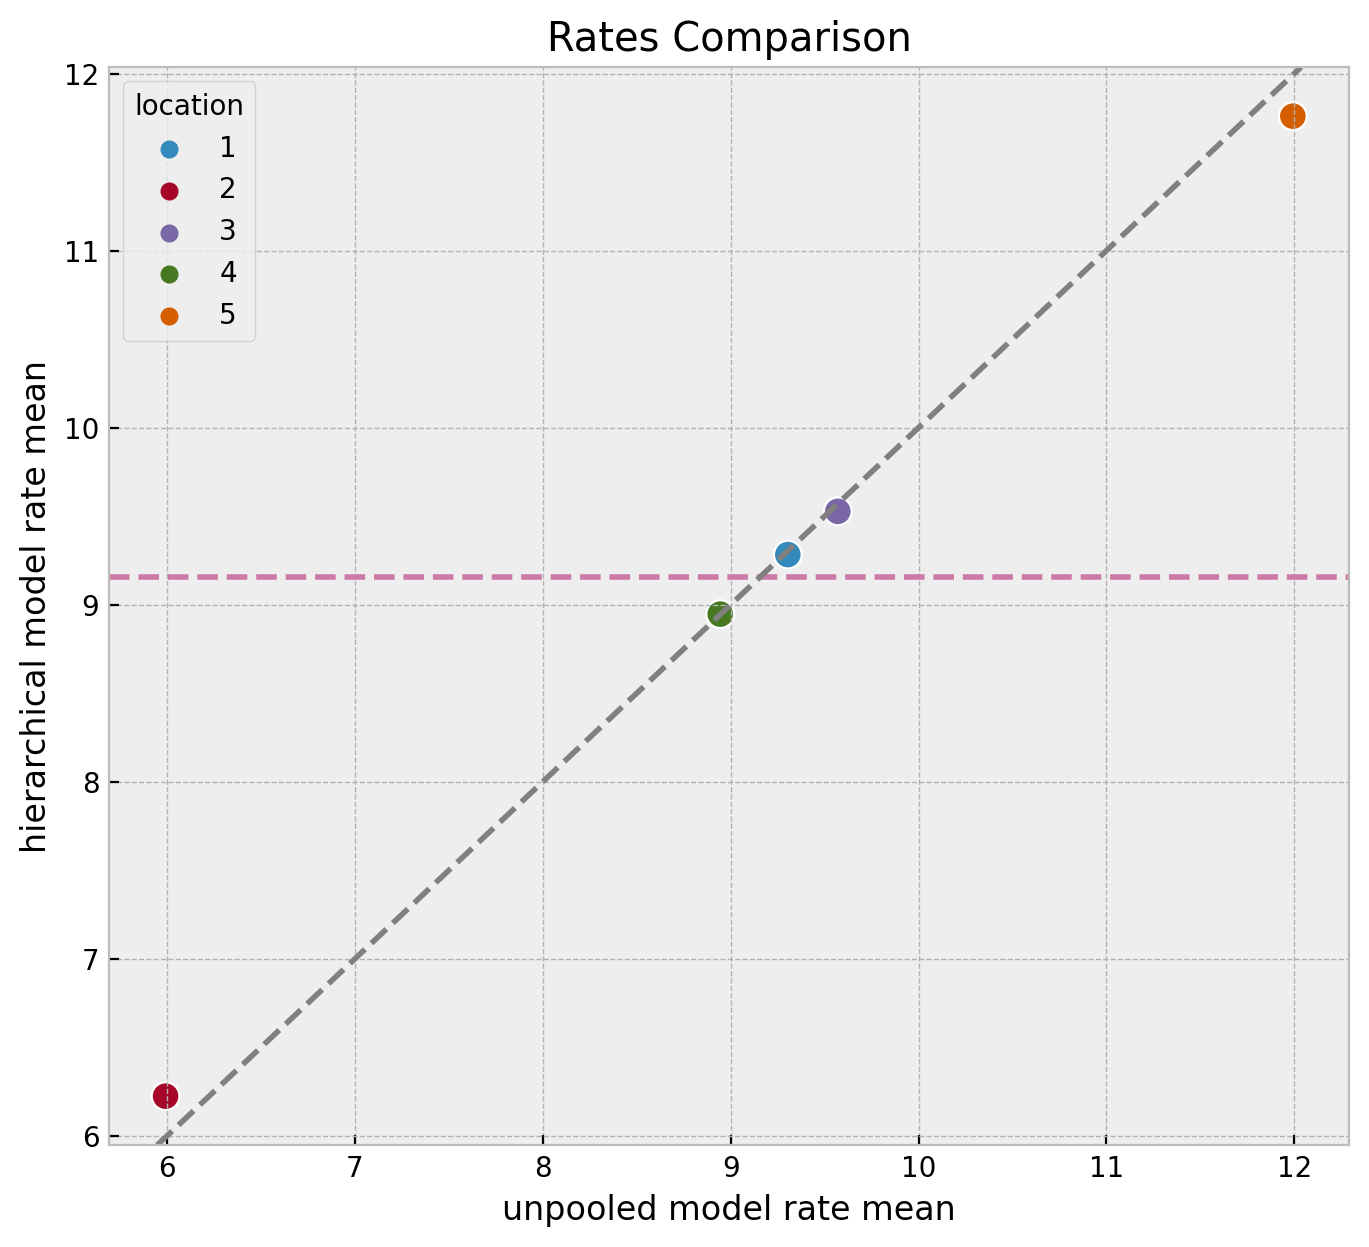

In [33]:
fig, ax = plt.subplots(figsize=(8, 7))

pd.DataFrame(
    data={
        "unpooled_lam_mean": unpooled_posterior_samples["lam"].mean(axis=0),
        "hierarchical_lam_mean": hierarchical_posterior_samples["lam"].mean(axis=0),
        "location": pd.Categorical(range(1, n_locations + 1)),
    }
).pipe(
    (sns.scatterplot, "data"),
    x="unpooled_lam_mean",
    y="hierarchical_lam_mean",
    hue="location",
    s=100,
    ax=ax,
)
ax.axhline(
    y=pooled_posterior_samples["rate"].mean(),
    color="C5",
    linestyle="--",
    label="pooled model rate mean",
)
ax.axline((9, 9), slope=1, color="gray", linestyle="--", label="diagonal")
ax.set(
    title="Rates Comparison",
    xlabel="unpooled model rate mean",
    ylabel="hierarchical model rate mean",
)

We clearly see the *shrinkage phenomenon* where the hierarchical model estimates are closer to the global mean than the unpooled model estimates. This is a consequence of the hierarchical model sharing information across locations. It serves as a regularization mechanism.

Note we see the same phenomenon at the level of distributions.

[Text(0.5, 1.0, 'Rates Comparison'), Text(0.5, 0, 'rate')]

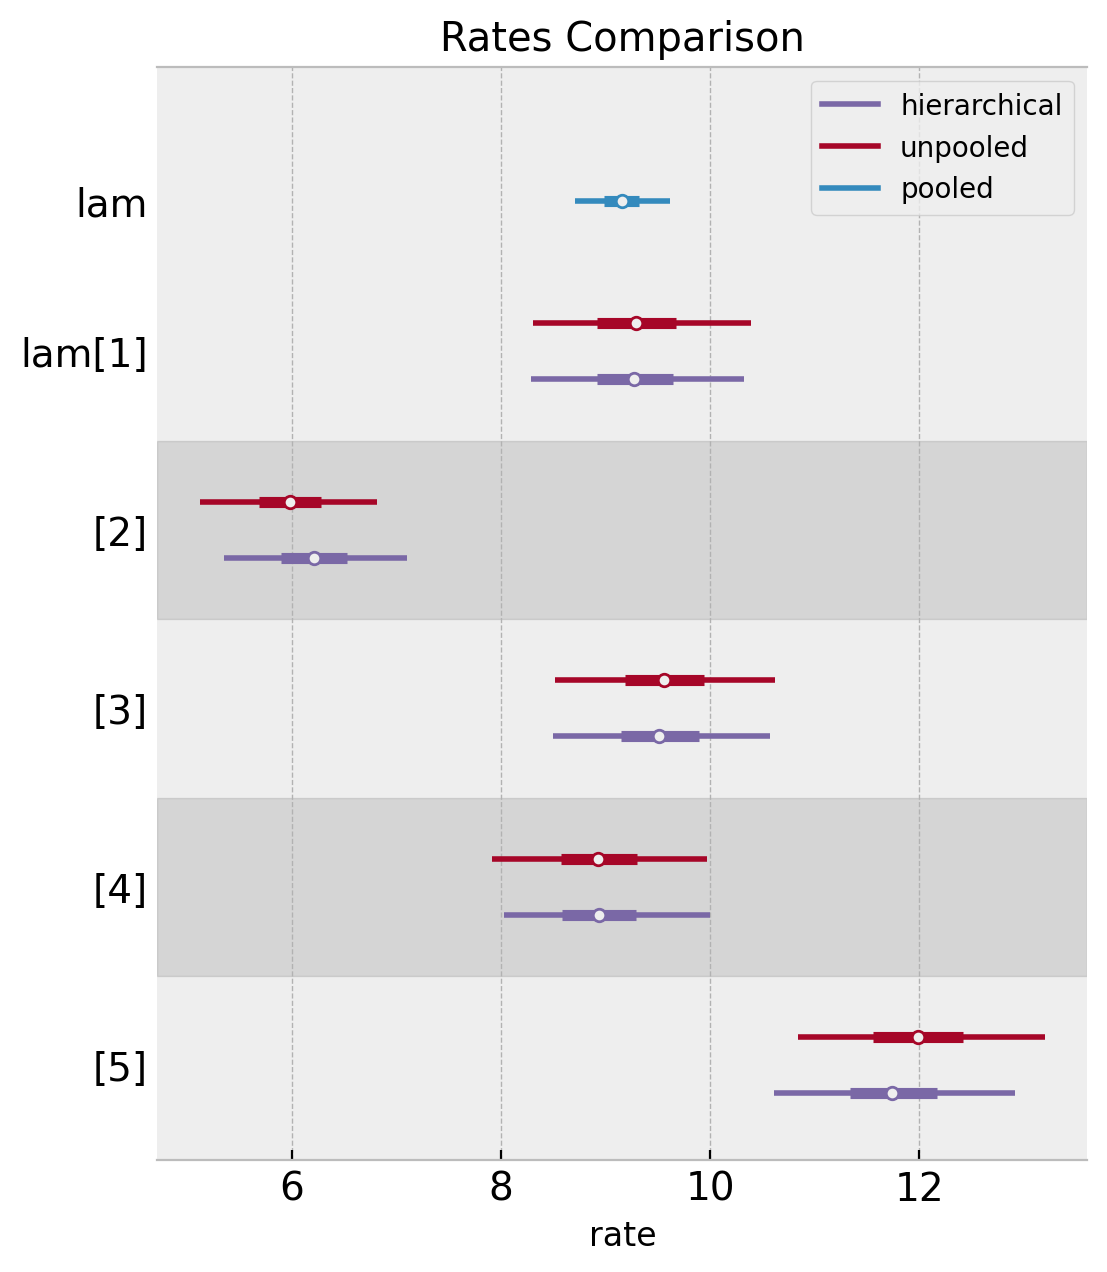

In [37]:
ax, *_ = az.plot_forest(
    data=[pooled_idata, unpooled_idata, hierarchical_idata],
    model_names=["pooled", "unpooled", "hierarchical"],
    var_names=["lam"],
    combined=True,
)
ax.set(title="Rates Comparison", xlabel="rate")


## Chips Distribution: New Location

Finally, we can estimate the chips distribution for a new location. We use the hierarchical model to estimate the distribution by sampling over the *hyper-priors* of $\mu$ and $\sigma$ and then passing the rate samples through the Poisson distribution.

[Text(0.5, 1.0, 'Chips Distribution for a New Location'),
 Text(0.5, 0, 'chips'),
 Text(0, 0.5, 'density')]

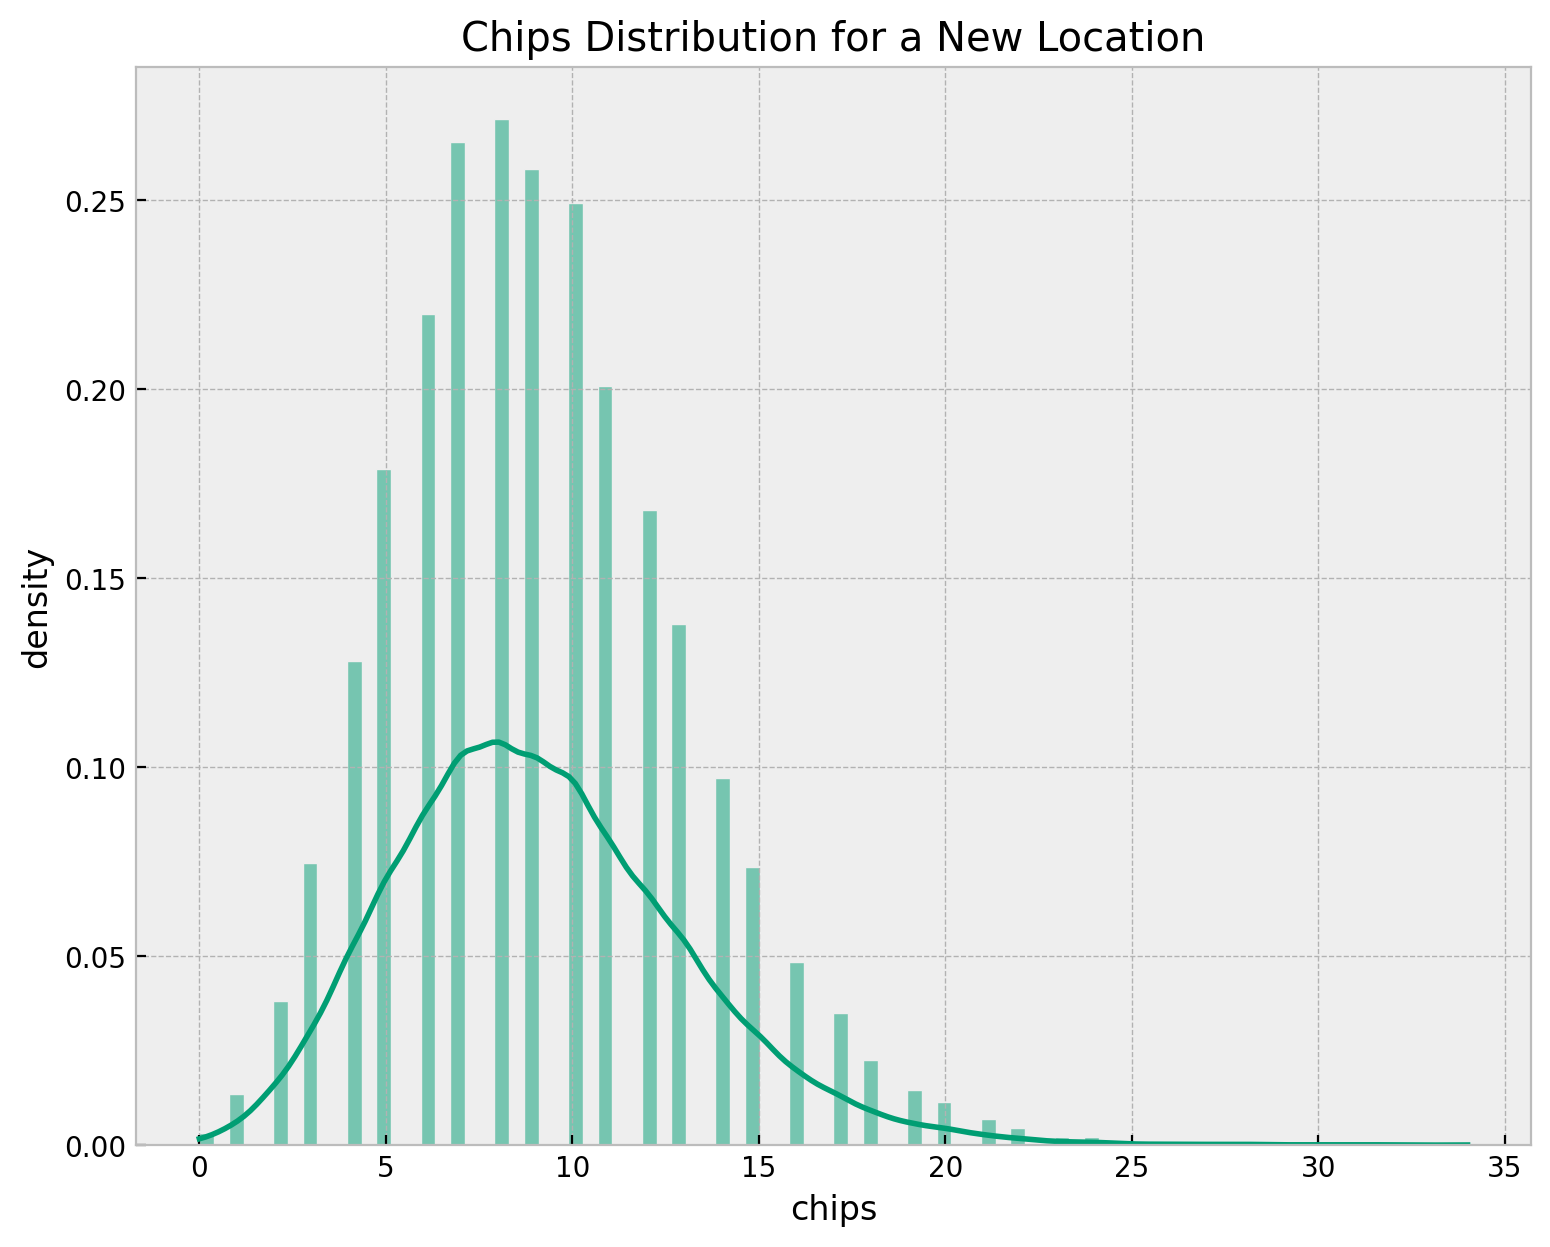

In [35]:
lam_dist = dist.Gamma(
    concentration=hierarchical_posterior_samples["alpha"],
    rate=hierarchical_posterior_samples["beta"],
)
rng_key, rng_subkey = random.split(rng_key)
lam_samples = lam_dist.sample(key=rng_subkey)
rng_key, rng_subkey = random.split(rng_key)
chips_samples = dist.Poisson(rate=lam_samples).sample(key=rng_subkey)

fig, ax = plt.subplots(figsize=(9, 7))
sns.histplot(x=chips_samples, kde=True, stat="density", color="C7", ax=ax)
ax.set(title="Chips Distribution for a New Location", xlabel="chips", ylabel="density")
